## 0. Imports and Setup

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


## 1. Data Cleaning
Load the LinkedIn job datasets, consolidate duplicate rows in auxiliary tables, enrich postings with company metadata, resolve basic missing values, and create a single analysis-ready table.

载入 LinkedIn 岗位相关数据，对辅助表（福利/技能/行业）做去重聚合，合并公司侧信息，处理基础缺失值，并生成统一的可分析数据表。

### Step 1. Load and Inspect the Dataset

Load all relevant CSV files into pandas DataFrames and inspect their shapes to understand the dataset structure.


In [8]:
data_root = "data/LinkedIn Job Postings (2023 - 2024)"

job_postings         = pd.read_csv(f"{data_root}/postings.csv")
benefits             = pd.read_csv(f"{data_root}/jobs/benefits.csv")
job_industries       = pd.read_csv(f"{data_root}/jobs/job_industries.csv")
job_skills           = pd.read_csv(f"{data_root}/jobs/job_skills.csv")

companies            = pd.read_csv(f"{data_root}/companies/companies.csv")
employee_counts      = pd.read_csv(f"{data_root}/companies/employee_counts.csv")
company_industries   = pd.read_csv(f"{data_root}/companies/company_industries.csv")
company_specialities = pd.read_csv(f"{data_root}/companies/company_specialities.csv")

skills_map           = pd.read_csv(f"{data_root}/mappings/skills.csv")
industries_map       = pd.read_csv(f"{data_root}/mappings/industries.csv")

In [9]:
print("shapes:",
      job_postings.shape, benefits.shape, job_industries.shape, job_skills.shape,
      companies.shape, employee_counts.shape, company_industries.shape, company_specialities.shape)

shapes: (123849, 31) (67943, 3) (164808, 2) (213768, 2) (24473, 10) (35787, 4) (24375, 2) (169387, 2)


### Step 2. Quick key uniqueness check

Confirm join keys are well-formed by counting unique ids in each table.
通过统计各表的主键/外键唯一值，快速确认连接键的基本有效性。


In [10]:
unique_values = {
    "job_postings (job_id)": job_postings["job_id"].nunique(),
    "benefits (job_id)": benefits["job_id"].nunique(),
    "job_industries (job_id)": job_industries["job_id"].nunique(),
    "job_skills (job_id)": job_skills["job_id"].nunique(),
    "companies (company_id)": companies["company_id"].nunique(),
    "employee_counts (company_id)": employee_counts["company_id"].nunique(),
    "company_industries (company_id)": company_industries["company_id"].nunique(),
    "company_specialities (company_id)": company_specialities["company_id"].nunique()
}
unique_values

{'job_postings (job_id)': 123849,
 'benefits (job_id)': 30023,
 'job_industries (job_id)': 127125,
 'job_skills (job_id)': 126807,
 'companies (company_id)': 24473,
 'employee_counts (company_id)': 24473,
 'company_industries (company_id)': 24365,
 'company_specialities (company_id)': 17780}

### Step 3. Consolidate benefits per job

In `benefits.csv`, remove the unrelated `inferred` column and aggregate duplicate `job_id` rows by concatenating `type`.
在 `benefits.csv` 中，删除与分析无关的 `inferred` 列，并按 `job_id` 聚合重复行，将福利类型 `type` 用逗号连接。



In [11]:
benefits = benefits.drop(columns=["inferred"])
benefits_agg = (
    benefits.groupby("job_id")["type"]
    .apply(lambda x: ", ".join(sorted(pd.unique(x))))
    .reset_index(name="benefits")
)
benefits_agg.head()

,job_id,benefits
0,23221523,401(k)
1,56482768,"401(k), Dental insurance, Disability insurance"
2,69333422,"401(k), Dental insurance, Medical insurance, V..."
3,95428182,"Dental insurance, Disability insurance, Medica..."
4,111513530,"Dental insurance, Medical insurance, Paid mate..."


### Step 4. Consolidate skills & industries per job
Aggregate job-level skills and industries; map to human-readable names using the mapping tables.
对岗位的技能与行业进行聚合；通过映射表转成可读名称。


In [12]:
# 左连接，job_skills 为主表
job_skills_named = job_skills.merge(skills_map, on="skill_abr", how="left")
skills_agg = (
    job_skills_named.groupby("job_id")["skill_name"]
    # 丢缺失值，去重，排序，拼接
    .apply(lambda x: ", ".join(sorted(pd.unique(x.dropna()))))
    .reset_index(name="skill_names")
)

job_industries_named = job_industries.merge(industries_map, on="industry_id", how="left")
inds_agg = (
    job_industries_named.groupby("job_id")["industry_name"]
    .apply(lambda x: ", ".join(sorted(pd.unique(x.dropna()))))
    .reset_index(name="industry_names")
)

In [13]:
skills_agg.head()

,job_id,skill_names
0,921716,"Marketing, Sales"
1,1218575,Health Care Provider
2,1829192,Health Care Provider
3,2264355,"Art/Creative, Design, Information Technology"
4,10998357,"Management, Manufacturing"


In [14]:
inds_agg.head()

,job_id,industry_names
0,921716,Real Estate
1,1218575,Hospitals and Health Care
2,2264355,Religious Institutions
3,9615617,Beverage Manufacturing
4,10998357,Restaurants


### Step 5.  Build company metadata

Create a compact company table: take the latest employee/follower counts by `time_recorded`, and aggregate company industries/specialities into lists.

构建紧凑的公司信息表：按 `time_recorded` 取员工数/粉丝数最新快照，并聚合公司行业与专长列表。

In [15]:
employee_counts["time_recorded"] = pd.to_datetime(
    employee_counts["time_recorded"].astype(float),
    unit="s",
    errors="coerce"
)

latest_emp = (
    employee_counts.sort_values(["company_id", "time_recorded"])
    .groupby("company_id", as_index=False)
    .tail(1)[["company_id","employee_count","follower_count","time_recorded"]]
)

comp_ind_agg = (
    company_industries.groupby("company_id")["industry"]
    .apply(lambda x: ", ".join(sorted(pd.unique(x.dropna()))))
    .reset_index(name="company_industries_list")
)
comp_spec_agg = (
    company_specialities.groupby("company_id")["speciality"]
    .apply(lambda x: ", ".join(sorted(pd.unique(x.dropna()))))
    .reset_index(name="company_specialities_list")
)

company_meta = (
    companies.merge(latest_emp, on="company_id", how="left")
             .merge(comp_ind_agg, on="company_id", how="left")
             .merge(comp_spec_agg, on="company_id", how="left")
)

company_meta.head(50)

,company_id,name,description,company_size,state,country,city,zip_code,address,url,employee_count,follower_count,time_recorded,company_industries_list,company_specialities_list
0,1009,IBM,"At IBM, we do more than work. We create. We cr...",7.0,NY,US,"Armonk, New York",10504,International Business Machines Corp.,https://www.linkedin.com/company/ibm,311223,16314846,2024-04-19 04:34:15,IT Services and IT Consulting,"Analytics, Cloud, Cognitive, Commerce, Consult..."
1,1016,GE HealthCare,Every day millions of people feel the impact o...,7.0,0,US,Chicago,0,-,https://www.linkedin.com/company/gehealthcare,57001,2196350,2024-04-19 23:23:51,Hospitals and Health Care,"Biotechnology, Healthcare"
2,1025,Hewlett Packard Enterprise,Official LinkedIn of Hewlett Packard Enterpris...,7.0,Texas,US,Houston,77389,1701 E Mossy Oaks Rd Spring,https://www.linkedin.com/company/hewlett-packa...,79559,3588329,2024-04-18 15:14:18,IT Services and IT Consulting,NaN
3,1028,Oracle,We’re a cloud technology company that provides...,7.0,Texas,US,Austin,78741,2300 Oracle Way,https://www.linkedin.com/company/oracle,191374,9497909,2024-04-19 15:21:13,IT Services and IT Consulting,"BEA, BPM, CRM, CRM On Demand, EPM, ERP, Hyperi..."
4,1033,Accenture,Accenture is a leading global professional ser...,7.0,0,IE,Dublin 2,0,Grand Canal Harbour,https://www.linkedin.com/company/accenture,565191,11890321,2024-04-19 23:30:51,Business Consulting and Services,"Application and Infrastructure Outsourcing, Bu..."
5,1035,Microsoft,Every company has a mission. What's ours? To e...,7.0,Washington,US,Redmond,98052,1 Microsoft Way,https://www.linkedin.com/company/microsoft,227317,22253257,2024-04-19 15:21:13,Software Development,"AI, Advertising, Artificial Intelligence, Busi..."
6,1038,Deloitte,Deloitte drives progress. Our firms around the...,7.0,0,OO,Worldwide,0,Worldwide,https://www.linkedin.com/company/deloitte,435078,15221049,2024-04-19 21:18:03,Business Consulting and Services,"Audit, Consulting, Financial Advisory, Risk Ma..."
7,1043,Siemens,Siemens AG (Berlin and Munich) is a leading te...,7.0,0,DE,Munich,80333,Werner-von-Siemens-Straße 1,https://www.linkedin.com/company/siemens,217641,6814908,2024-04-18 16:24:32,Automation Machinery Manufacturing,"Artificial Intelligence, Automation, Cybersecu..."
8,1044,PwC,"At PwC, our purpose is to build trust in socie...",7.0,0,GB,0,0,1 Embankment Place,https://www.linkedin.com/company/pwc,291883,6085704,2024-04-18 16:45:10,IT Services and IT Consulting,"Advisory, Assurance, Tax"
9,1052,AT&T,We understand that our customers want an easie...,7.0,TX,US,Dallas,75202,208 S. Akard Street,https://www.linkedin.com/company/att,174692,1485885,2024-04-19 18:14:17,Telecommunications,Enterprise Applications & Managed Hosting Solu...


### Step 6.  Merge into the main postings table

Start from `postings.csv`, then left-join benefits/skills/industries by `job_id`, and company metadata by `company_id`.

以 `postings.csv` 为主表，按 `job_id` 左连接福利/技能/行业信息，再按 `company_id` 左连接公司信息。

In [16]:
merged_jobs = (
    job_postings
    .merge(benefits_agg, on="job_id", how="left")
    .merge(skills_agg,   on="job_id", how="left")
    .merge(inds_agg,     on="job_id", how="left")
)

merged_companies = company_meta

df = merged_jobs.merge(
    merged_companies[
        ["company_id","name","company_size","country","city","zip_code","address","url",
         "employee_count","follower_count","time_recorded","company_industries_list","company_specialities_list"]
    ],
    on="company_id", how="left"
)

print("merged shape:", df.shape)
df.head()

merged shape: (123849, 46)


,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,country,city,zip_code_y,address,url,employee_count,follower_count,time_recorded,company_industries_list,company_specialities_list
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,US,Jersey City,07302,242 Tenth Street,https://www.linkedin.com/company/corcoran-sawy...,402.0,2351.0,2024-04-18 03:01:15,Real Estate,"new development, real estate"
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,US,Mariemont,45227,6880 Wooster Pike,https://www.linkedin.com/company/the-national-...,15.0,40.0,2024-04-16 14:55:21,Restaurants,NaN
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,US,Lake Success,11042,3 Dakota Drive,https://www.linkedin.com/company/abrams-fenste...,222.0,2427.0,2024-04-12 04:48:19,Law Practice,"Appellate, Civil Litigation, Corporate & Secur..."
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN


### Step 7. Basic value normalization & column pruning
Standardize common categorical fields, drop analysis-irrelevant duplicate columns (e.g., `zip_code_x`, `zip_code_y`), and create a simple work-mode flag.
For now we **skip salary calculation** due to heavy missingness.

规范化常用的分类字段，**移除与分析无关的重复列**（如 `zip_code_x`、`zip_code_y`），并生成简易的工作模式标记。
由于薪资缺失较多，本阶段**暂不计算**相关派生值。

> `zip_code_x`、`zip_code_y` 源自于相同字段合并时pandas会自动分裂


In [17]:
print(df.columns.tolist())

['job_id', 'company_name', 'title', 'description', 'max_salary', 'pay_period', 'location', 'company_id', 'views', 'med_salary', 'min_salary', 'formatted_work_type', 'applies', 'original_listed_time', 'remote_allowed', 'job_posting_url', 'application_url', 'application_type', 'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc', 'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency', 'compensation_type', 'normalized_salary', 'zip_code_x', 'fips', 'benefits', 'skill_names', 'industry_names', 'name', 'company_size', 'country', 'city', 'zip_code_y', 'address', 'url', 'employee_count', 'follower_count', 'time_recorded', 'company_industries_list', 'company_specialities_list']


In [18]:
cols_to_drop = [c for c in ["zip_code_x", "zip_code_y"] if c in df.columns]
df.drop(columns=cols_to_drop, inplace=True)

In [19]:
def simple_remote_flag(s):
    s = str(s).lower()
    if "remote" in s:
        return "remote"
    if "hybrid" in s:
        return "hybrid"
    if "on-site" in s or "onsite" in s or "on site" in s:
        return "on-site"
    return "Not Specified"

df["remote_flag_simple"] = df["formatted_work_type"].apply(simple_remote_flag)

In [20]:
fill_cat = [
    "title","description","location","formatted_work_type","remote_flag_simple",
    "formatted_experience_level","skill_names","industry_names","benefits",
    "pay_period","currency","compensation_type","company_size","country","city",
    "address","url","name","posting_domain","application_url"
]
for c in fill_cat:
    df[c] = df[c].fillna("Not Specified").astype(str).str.strip()

In [21]:
fill_num = ["applies","views","employee_count","follower_count"]
for c in fill_num:
    df[c] = df[c].fillna(0)

In [22]:
df["country"] = (
        df["country"]
        .astype(str)
        .str.strip()
        .replace(["", "nan", "NaN", "0", "None", "unknown", "not specified"], "Unknown")
    )

In [23]:
df["remote_allowed"] = df["remote_allowed"].fillna("Unknown")

In [24]:
print(df.columns.tolist())

['job_id', 'company_name', 'title', 'description', 'max_salary', 'pay_period', 'location', 'company_id', 'views', 'med_salary', 'min_salary', 'formatted_work_type', 'applies', 'original_listed_time', 'remote_allowed', 'job_posting_url', 'application_url', 'application_type', 'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc', 'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency', 'compensation_type', 'normalized_salary', 'fips', 'benefits', 'skill_names', 'industry_names', 'name', 'company_size', 'country', 'city', 'address', 'url', 'employee_count', 'follower_count', 'time_recorded', 'company_industries_list', 'company_specialities_list', 'remote_flag_simple']


In [25]:
df.head(10)

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,country,city,address,url,employee_count,follower_count,time_recorded,company_industries_list,company_specialities_list,remote_flag_simple
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,US,Jersey City,242 Tenth Street,https://www.linkedin.com/company/corcoran-sawy...,402.0,2351.0,2024-04-18 03:01:15,Real Estate,"new development, real estate",Not Specified
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,Not Specified,Not Specified,Not Specified,Not Specified,0.0,0.0,NaT,NaN,NaN,Not Specified
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,US,Mariemont,6880 Wooster Pike,https://www.linkedin.com/company/the-national-...,15.0,40.0,2024-04-16 14:55:21,Restaurants,NaN,Not Specified
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,US,Lake Success,3 Dakota Drive,https://www.linkedin.com/company/abrams-fenste...,222.0,2427.0,2024-04-12 04:48:19,Law Practice,"Appellate, Civil Litigation, Corporate & Secur...",Not Specified
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,Not Specified,Not Specified,Not Specified,Not Specified,0.0,0.0,NaT,NaN,NaN,Not Specified
5,91700727,Downtown Raleigh Alliance,Economic Development and Planning Intern,Job summary:The Economic Development & Plannin...,20.0,HOURLY,"Raleigh, NC",1481176.0,9.0,NaN,...,US,Raleigh,333 Fayetteville St,https://www.linkedin.com/company/downtownralei...,22.0,7825.0,2024-04-18 17:04:11,Non-profit Organizations,"Accessibility, Activations, Business Support, ...",Not Specified
6,103254301,Raw Cereal,Producer,Company DescriptionRaw Cereal is a creative de...,300000.0,YEARLY,United States,81942316.0,7.0,NaN,...,US,Los Angeles,0,https://www.linkedin.com/company/raw-cereal,11.0,447.0,2024-04-11 18:46:42,Design Services,NaN,Not Specified
7,112576855,NaN,Building Engineer,Summary: Due to the pending retirement of our ...,120000.0,YEARLY,"San Francisco, CA",NaN,2.0,NaN,...,Not Specified,Not Specified,Not Specified,Not Specified,0.0,0.0,NaT,NaN,NaN,Not Specified
8,1218575,Children's Nebraska,Respiratory Therapist,"At Children’s, the region’s only full-service ...",NaN,Not Specified,"Omaha, NE",721189.0,3.0,NaN,...,US,Omaha,8200 Dodge Street,https://www.linkedin.com/company/childrensnebr...,1793.0,13313.0,2024-04-18 22:29:14,Hospitals and Health Care,"Cardiology, Critical Care, Developmental Pedia...",Not Specified
9,2264355,Bay West Church,Worship Leader,It is an exciting time to be a part of our chu...,NaN,MONTHLY,"Palm Bay, FL",28631247.0,5.0,350.0,...,US,Melbourne,3301 Dairy Rd,https://www.linkedin.com/company/bay-west-church,1.0,3.0,2024-04-07 03:08:31,Religious Institutions,"Biblical preaching, Discipling/mentoring, Kid'...",Not Specified


### Step 8.  Final tidy-up and export

Drop exact duplicate rows, keep a compact column order, and save a cleaned CSV for downstream analysis.

删除完全重复行，整理列顺序，并导出清洗后的 CSV 供后续分析使用。


In [26]:
df_clean = df.drop_duplicates().copy()

cols_order = [
    # keys
    "job_id", "company_id",
    # job
    "title", "description", "location", "formatted_work_type", "remote_flag_simple",
    "formatted_experience_level", "skill_names", "industry_names", "benefits",
    # salary
    "pay_period", "currency", "compensation_type",
    "min_salary", "med_salary", "max_salary", "avg_salary",
    # company
    "name", "company_size", "country", "city", "address", "url",
    "employee_count", "follower_count",
    "company_industries_list", "company_specialities_list",
    # misc
    "posting_domain", "application_url", "applies", "views",
    "remote_allowed", "time_recorded"
]

cols_order = [c for c in cols_order if c in df_clean.columns]

df_clean = df_clean[cols_order + [c for c in df_clean.columns if c not in cols_order]]

out_path = "data/cleaned_data/cleaned_postings.csv"
os.makedirs(os.path.dirname(out_path), exist_ok=True)

df_clean.to_csv(out_path, index=False)
df_clean.head(10)

,job_id,company_id,title,description,location,formatted_work_type,remote_flag_simple,formatted_experience_level,skill_names,industry_names,...,job_posting_url,application_type,expiry,closed_time,skills_desc,listed_time,sponsored,work_type,normalized_salary,fips
0,921716,2774458.0,Marketing Coordinator,Job descriptionA leading real estate firm in N...,"Princeton, NJ",Full-time,Not Specified,Not Specified,"Marketing, Sales",Real Estate,...,https://www.linkedin.com/jobs/view/921716/?trk...,ComplexOnsiteApply,1.715990e+12,NaN,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,0,FULL_TIME,38480.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...","Fort Collins, CO",Full-time,Not Specified,Not Specified,Health Care Provider,Not Specified,...,https://www.linkedin.com/jobs/view/1829192/?tr...,ComplexOnsiteApply,1.715450e+12,NaN,NaN,1.712858e+12,0,FULL_TIME,83200.0,8069.0
2,10998357,64896719.0,Assitant Restaurant Manager,The National Exemplar is accepting application...,"Cincinnati, OH",Full-time,Not Specified,Not Specified,"Management, Manufacturing",Restaurants,...,https://www.linkedin.com/jobs/view/10998357/?t...,ComplexOnsiteApply,1.715870e+12,NaN,We are currently accepting resumes for FOH - A...,1.713278e+12,0,FULL_TIME,55000.0,39061.0
3,23221523,766262.0,Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,"New Hyde Park, NY",Full-time,Not Specified,Not Specified,Other,Law Practice,...,https://www.linkedin.com/jobs/view/23221523/?t...,ComplexOnsiteApply,1.715488e+12,NaN,This position requires a baseline understandin...,1.712896e+12,0,FULL_TIME,157500.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,"Burlington, IA",Full-time,Not Specified,Not Specified,Information Technology,Facilities Services,...,https://www.linkedin.com/jobs/view/35982263/?t...,ComplexOnsiteApply,1.716044e+12,NaN,NaN,1.713452e+12,0,FULL_TIME,70000.0,19057.0
5,91700727,1481176.0,Economic Development and Planning Intern,Job summary:The Economic Development & Plannin...,"Raleigh, NC",Internship,Not Specified,Not Specified,Project Management,Non-profit Organization Management,...,https://www.linkedin.com/jobs/view/91700727/?t...,ComplexOnsiteApply,1.716048e+12,NaN,NaN,1.713456e+12,0,INTERNSHIP,35360.0,37183.0
6,103254301,81942316.0,Producer,Company DescriptionRaw Cereal is a creative de...,United States,Contract,Not Specified,Not Specified,"Art/Creative, Design, Information Technology",Design Services,...,https://www.linkedin.com/jobs/view/103254301/?...,SimpleOnsiteApply,1.715453e+12,NaN,NaN,1.712861e+12,0,CONTRACT,180000.0,NaN
7,112576855,NaN,Building Engineer,Summary: Due to the pending retirement of our ...,"San Francisco, CA",Full-time,Not Specified,Not Specified,"Management, Manufacturing","Food and Beverage Services, Hospitality",...,https://www.linkedin.com/jobs/view/112576855/?...,ComplexOnsiteApply,1.727995e+12,NaN,NaN,1.712443e+12,0,FULL_TIME,105000.0,6075.0
8,1218575,721189.0,Respiratory Therapist,"At Children’s, the region’s only full-service ...","Omaha, NE",Full-time,Not Specified,Not Specified,Health Care Provider,Hospitals and Health Care,...,https://www.linkedin.com/jobs/view/1218575/?tr...,OffsiteApply,1.714940e+12,NaN,• Requires the ability to communicate effectiv...,1.712348e+12,0,FULL_TIME,NaN,31055.0
9,2264355,28631247.0,Worship Leader,It is an exciting time to be a part of our chu...,"Palm Bay, FL",Part-time,Not Specified,Not Specified,"Art/Creative, Design, Information Technology",Religious Institutions,...,https://www.linkedin.com/jobs/view/2264355/?tr...,ComplexOnsiteApply,1.715048e+12,NaN,"Knowledge, Skills and Abilities: 1. Proficient...",1.712456e+12,0,PART_TIME,4200.0,12009.0


                               count  unique  \
job_id                      123849.0     NaN   
company_id                  122132.0     NaN   
title                         123849   72106   
description                   123849  107759   
location                      123849    8526   
formatted_work_type           123849       7   
remote_flag_simple            123849       1   
formatted_experience_level    123849       7   
skill_names                   123849    2037   
industry_names                123849    4524   

                                                                          top  \
job_id                                                                    NaN   
company_id                                                                NaN   
title                                                           Sales Manager   
description                 Position Summary: Our Sales Manager has managi...   
location                                                        Un

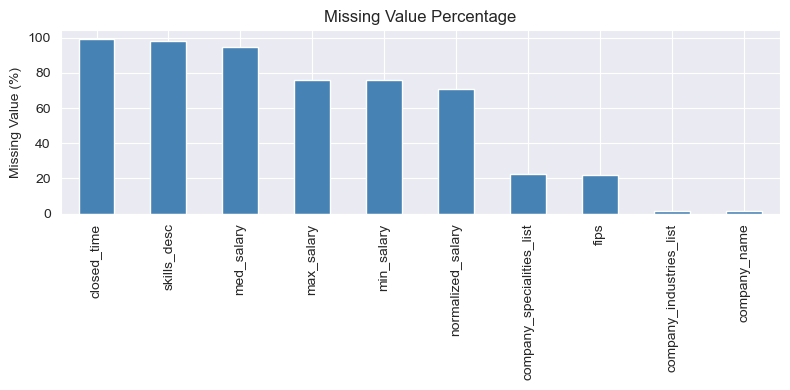

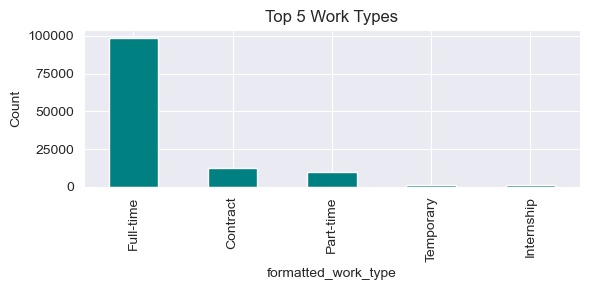

In [27]:
print(df_clean.describe(include='all').transpose().head(10))

plt.figure(figsize=(8, 4))
(df_clean.isnull().mean() * 100).sort_values(ascending=False).head(10).plot(kind='bar', color='steelblue')
plt.title("Missing Value Percentage")
plt.ylabel("Missing Value (%)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
df_clean["formatted_work_type"].value_counts().head(5).plot(kind="bar", color="teal")
plt.title("Top 5 Work Types")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## 2. RQ1: Market Signals in Job Roles, Skills, and Benefits
This section examines the key market signals reflected in LinkedIn job postings, including job roles, in-demand skills, and benefit offerings.
Beyond identifying which positions and competencies are most sought after, the analysis also explores how companies use benefits to enhance job attractiveness.
By comparing these patterns across industries and employment types, the study highlights how organizations balance skill requirements, incentives, and workforce appeal in a competitive labor market.

本章节探讨 LinkedIn 岗位发布中反映的主要市场信号，包括职位分布、技能需求及福利待遇特征。
除了识别最受欢迎的岗位与技能外，本节还分析企业如何通过福利策略提升岗位吸引力。
通过对不同行业及用工类型的比较，研究揭示了组织在竞争性劳动力市场中如何平衡技能要求、激励机制与岗位吸引力。


In [28]:
df_clean = pd.read_csv("data/cleaned_data/cleaned_postings.csv")

### 2.1 Most Common Job Titles
We first examine which job titles appear most frequently in the dataset.
This helps identify dominant occupational categories and offers an overview of market concentration.
In addition to a frequency bar chart of the top 15 titles, a word cloud is generated to visualize the overall prominence of different roles based on their posting frequency.

本节首先分析数据集中最常见的职位名称，以识别主导性的岗位类别并了解市场聚焦方向。
除了展示前 15 个职位的频次条形图外，我们还生成了词云图，用于直观呈现职位名称的整体分布及其相对重要性。

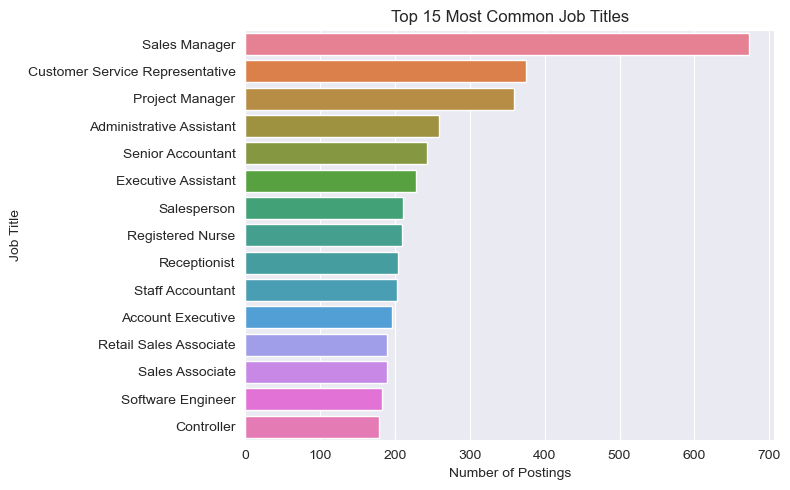

In [29]:
title_counts = (
    df_clean["title"]
    .astype(str) # 确保字符串类型
    .str.strip() # 去掉首尾空格
    .value_counts() # 默认降序排列
    .head(15)
)

plt.figure(figsize=(8,5))
# 使用示例：sns.barplot(penguins, x="body_mass_g", y="island", hue="island", legend=False)
sns.barplot(
    x=title_counts.values,
    y=title_counts.index,
    hue=title_counts.index,
    legend=False
)

plt.title("Top 15 Most Common Job Titles")
plt.xlabel("Number of Postings")
plt.ylabel("Job Title")
plt.tight_layout() # 自动调整边距，文字过长图像会收缩免得不好看
plt.show()

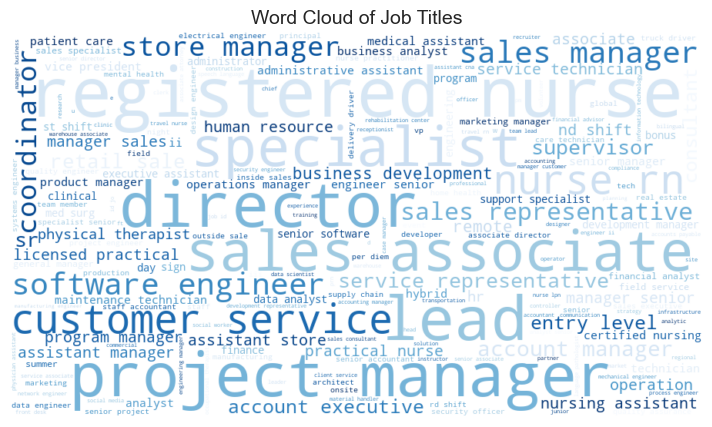

In [30]:
from wordcloud import WordCloud
import re

# note: 测试时有些与具体职业类型无关的词出现在云图里，临时手动去掉
# 检查发现原始数据集的title列中本身包含这些前缀，可能需要进一步处理
stopwords = {"full", "time", "part", "temporary", "contract", "intern", "internship"}

titles_cleaned = (
    df_clean["title"]
    .dropna()
    .astype(str)
    .str.lower() # 统一大小写
    .apply(lambda x: re.sub(r"[^a-z\s]", " ", x)) # 只保留英文字母和空格
    .apply(lambda x: " ".join([w for w in x.split() if w not in stopwords])) # 去掉手动筛选出来的一些词
)

wc = WordCloud(
    width=900,
    height=500,
    background_color="white",
    colormap="Blues",
    max_words=200
).generate(" ".join(titles_cleaned))

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Job Titles", fontsize=14)
plt.show()

#### Analysis
The analysis of job titles reveals several dominant occupational categories in the dataset.
The bar chart of the top 15 titles highlights highly recurring positions such as *Sales Manager*, *Customer Service Representative*, and *Project Manager*, indicating strong market demand in sales, administrative, and managerial roles.
In contrast, the word cloud, which considers all job titles, emphasizes broader categories such as *Registered Nurse*, *Director*, *Specialist*, and *Engineer*, providing a holistic view of the job market structure.
The slight differences between the two visualizations arise from their analytical scope and preprocessing methods—while the bar chart focuses on exact job titles and their discrete frequencies, the word cloud aggregates text-level occurrences across all postings, merging similar terms and reflecting overall semantic prominence.

对职位名称的分析显示数据集中若干主要的职业类别。
前 15 职位的条形图突出了如销售经理、客户服务代表、项目经理等高频岗位，反映出市场对销售、行政与管理类职位的集中需求。
相比之下，基于全部职位生成的词云更强调注册护士、主管、专员及工程师等广义岗位类别，提供了对就业市场结构的整体视角。
两种可视化结果略有差异，主要源于分析范围与文本预处理方式的不同，条形图侧重具体职位名称及其频次，而词云汇总了所有文本层级的词频，合并相似表达并呈现语义层面的整体分布。

### 2.2 Top Required Skills
Next, we analyze which skills are most frequently requested in postings.
By splitting the aggregated `skill_names` column, we can count overall demand for each skill.
This reflects both technical and soft skill trends on LinkedIn.

接着分析岗位中最常出现的技能类型。
我们将 `skill_names` 列拆分聚合，统计技能出现频次，以反映 LinkedIn 招聘市场中硬技能与软技能的总体趋势。


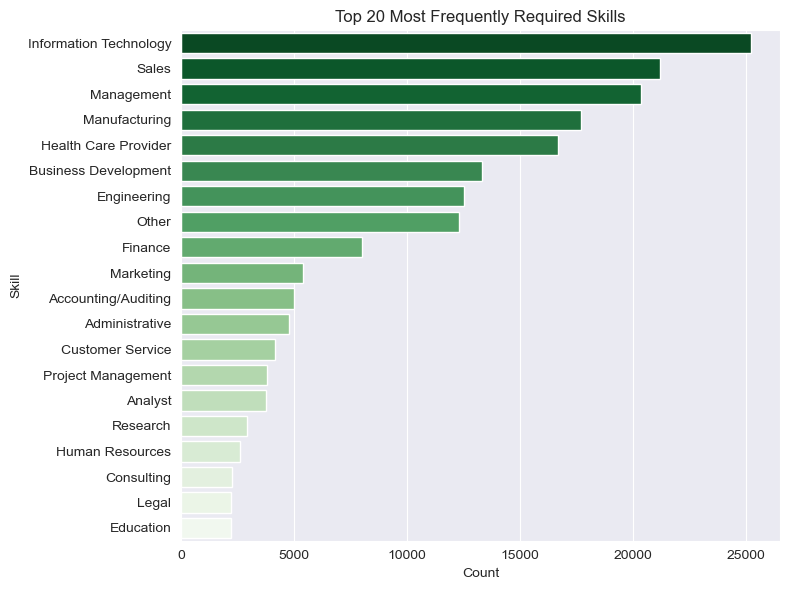

Information Technology    25256
Sales                     21193
Management                20385
Manufacturing             17728
Health Care Provider      16675
Business Development      13304
Engineering               12530
Other                     12314
Finance                    8011
Marketing                  5400
Accounting/Auditing        4999
Administrative             4787
Customer Service           4167
Project Management         3825
Analyst                    3775
Research                   2928
Human Resources            2608
Consulting                 2241
Legal                      2229
Education                  2217
Name: count, dtype: int64

In [31]:
skill_series = df_clean["skill_names"].dropna().astype(str).str.split(",")
skills_flat = [s.strip() for sublist in skill_series for s in sublist if s.strip() != ""]
skill_counts = pd.Series(skills_flat).value_counts().head(20)

plt.figure(figsize=(8,6))
sns.barplot(
    x=skill_counts.values,
    y=skill_counts.index,
    hue=skill_counts.index,
    palette="Greens_r",
    legend=False
)
plt.title("Top 20 Most Frequently Required Skills")
plt.xlabel("Count")
plt.ylabel("Skill")
plt.tight_layout()
plt.show()

skill_counts

#### Analysis
The skill frequency distribution indicates that **Information Technology**, **Sales**, and **Management** are the three most in-demand domains on LinkedIn job postings.
This highlights the dual engine of today’s job market — technology and business — driving most employment opportunities.
Technical functions (IT, Engineering, Manufacturing) show high demand alongside leadership-oriented skills (Management, Business Development), reflecting the ongoing digital transformation in multiple industries.

The prominence of **Health Care Provider** and **Manufacturing** signals continued hiring in essential and production-based sectors, possibly influenced by post-pandemic recovery and reshoring trends.
Similarly, **Finance**, **Marketing**, and **Accounting/Auditing** retain their importance, revealing stable demand for core business operations.

从技能分布来看，**信息技术**、**销售** 与 **管理** 位列最受欢迎技能前三，显示当前就业市场的双引擎——技术与商务——共同驱动岗位需求。
技术类（如 IT、工程、制造）与领导管理类（如管理、业务拓展）技能并列高位，反映出多行业的数字化转型趋势。

**医疗** 与 **制造业** 的高需求则表明后疫情时代基础与生产性行业仍在稳步扩张，部分受产业回流与自动化转型推动。
与此同时，**金融**、**市场** 与 **会计审计** 等职能仍保持稳定需求，显示核心业务支持岗位的长期重要性。

Overall, the market demonstrates a balanced demand between **digital expertise** and **organizational management capabilities**, suggesting that cross-disciplinary skill sets will continue to provide competitive advantages.

总体而言，市场对**数字技术能力**与**组织管理能力**的需求较为均衡，说明具备跨领域技能组合的候选人将在未来就业市场中更具竞争力。


### 2.3 Skill Demand by Industry
To better understand how skill requirements differ by industry, we examine the intersection between `industry_names` and `skill_names`.
Instead of only counting total occurrences, we visualize which industries most frequently emphasize specific skills.

为更直观地理解各行业之间的技能需求差异，本节分析 `industry_names` 与 `skill_names` 的交叉分布，
并展示各行业中最常出现的技能，以揭示行业特征与技能倾向。

> explode() 可以把列表型数据拆分成多个行
```
df
Out[96]:
     keys            values
0  panda1    [eats, shoots]
1  panda2  [shoots, leaves]
2  panda3    [eats, leaves]

df["values"].explode()
Out[97]:
0      eats
0    shoots
1    shoots
1    leaves
2      eats
2    leaves
Name: values, dtype: object
```

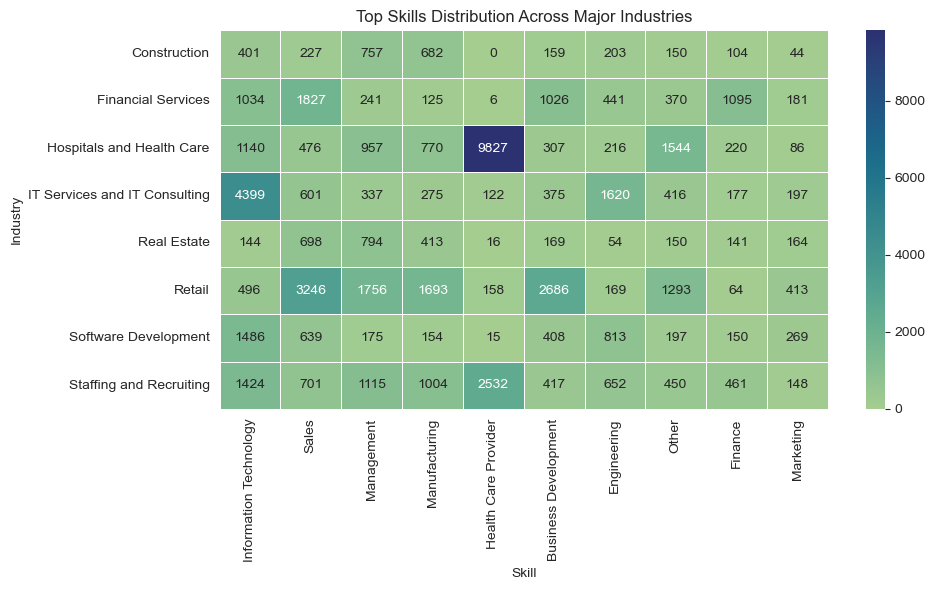

In [32]:
skills_explode = (
    df_clean[["industry_names", "skill_names"]]
    .dropna()
    .assign(skill_names=lambda x: x["skill_names"].str.split(","))
    .explode("skill_names")
)
skills_explode["skill_names"] = skills_explode["skill_names"].str.strip()

top_industries = (
    skills_explode["industry_names"]
    .value_counts()
    .head(8)
    .index.tolist()
)
top_skills = (
    skills_explode["skill_names"]
    .value_counts()
    .head(10)
    .index.tolist()
)

pivot_df = pd.crosstab(
    skills_explode["industry_names"],
    skills_explode["skill_names"]
)
pivot_df = pivot_df.loc[pivot_df.index.isin(top_industries), top_skills]

plt.figure(figsize=(10,6))

# sns.heatmap(glue, annot=True, linewidth=.5)
# sns.heatmap(glue, cmap="crest")
# sns.heatmap(glue, cmap=sns.cubehelix_palette(as_cmap=True))
sns.heatmap(
    pivot_df,
    cmap="crest",
    annot=True,
    linewidths=0.5,
    fmt="d" # 否则会以科学计数法显示
)
plt.title("Top Skills Distribution Across Major Industries")
plt.xlabel("Skill")
plt.ylabel("Industry")
plt.tight_layout()
plt.show()

#### Analysis
The heatmap clearly illustrates **distinct skill specialization across industries**.
- **Hospitals and Health Care** overwhelmingly emphasize the **Health Care Provider** skill, far exceeding all other categories (9827 occurrences). This indicates strong specialization and certification-driven hiring in the healthcare sector.
- **IT Services and IT Consulting** show exceptionally high counts in **Information Technology** (4399) and **Engineering**, confirming that technology-related roles dominate this industry’s job landscape.
- **Retail** places heavy focus on **Sales** (3246) and **Management** skills, reflecting the sector’s operational dependency on customer interaction and branch leadership.
- **Staffing and Recruiting** and **Business Development** roles emphasize a mix of **Health Care Provider**, **Management**, and **Sales**, suggesting that cross-functional coordination and interpersonal communication remain core capabilities in HR-related businesses.
- **Financial Services** highlight **Sales**, **Finance**, and **Information Technology**, pointing to hybrid roles that blend financial expertise with digital platforms.
- **Construction** and **Manufacturing** industries show moderate emphasis on **Management** and **Manufacturing**, indicating stable but smaller-scale technical demand compared to digital sectors.

Overall, the map confirms that **industry-specific specialization remains strong**, yet the presence of cross-cutting competencies such as management, IT, and sales in nearly all industries suggests convergence toward multidisciplinary skill sets in the post-digital labor market.

热力图清晰地展示出各行业在技能需求上的**显著差异**：
- **医疗与健康护理（Hospitals and Health Care）** 对 **医疗专业（Health Care Provider）** 的依赖度极高（9827 次），显示出该领域的强专业化与资质导向型招聘特征。
- **信息技术服务（IT Services and IT Consulting）** 在 **信息技术（Information Technology）** 与 **工程（Engineering）** 上占据主导（4399 次），说明技术类岗位是该行业的核心组成。
- **零售业（Retail）** 强调 **销售（Sales）** 与 **管理（Management）**，反映出该行业依赖客户交互与门店管理的运营特性。
- **人力资源与招聘（Staffing and Recruiting）** 结合了 **医疗、销售与管理** 技能，表明跨部门协调与沟通能力在此类岗位中尤为重要。
- **金融服务（Financial Services）** 则在 **销售、金融与信息技术** 之间形成混合型需求，反映出数字化转型下的复合岗位趋势。
- **建筑（Construction）** 与 **制造（Manufacturing）** 行业在 **管理** 与 **制造** 技能上表现稳定，但整体技术密集度相对较低。

整体来看，不同行业依然保持其**专业化技能核心**，但诸如 **信息技术、销售与管理** 等通用能力几乎出现在所有行业中，
这表明在后数字化时代，就业市场正逐步向多技能融合型岗位演化。


### 2.4 Benefit Offerings and Market Attractiveness
This subsection summarizes how employers signal job attractiveness through benefit offerings (e.g., health insurance, paid leave, flexible work).
We first profile the most frequently advertised benefits across postings to understand baseline incentives.

本小节概览用人单位通过福利待遇（如医疗保险、带薪休假、灵活办公等）传递岗位吸引力的方式。
我们先统计最常出现的福利类型，作为市场激励的基线画像。

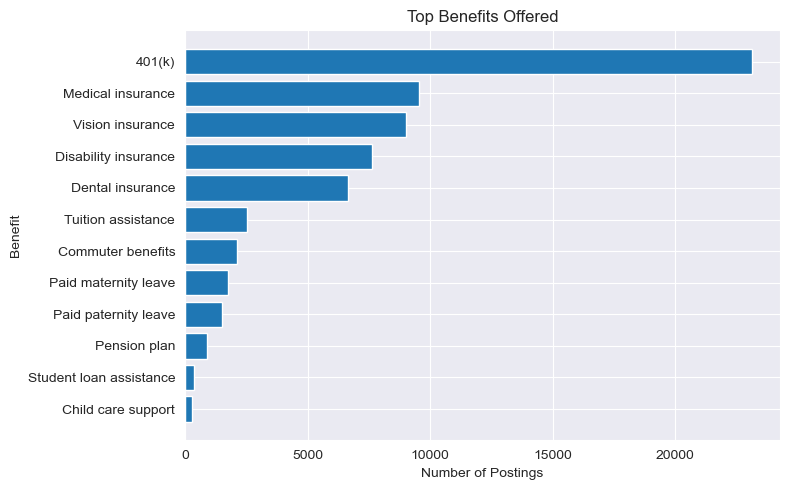

benefits
401(k)                     23109
Medical insurance           9560
Vision insurance            9004
Disability insurance        7631
Dental insurance            6654
Tuition assistance          2526
Commuter benefits           2116
Paid maternity leave        1773
Paid paternity leave        1500
Pension plan                 883
Student loan assistance      365
Child care support           272
Name: count, dtype: int64

In [33]:
benefits = (
    df_clean["benefits"]
    .dropna()
    .astype(str)
    .str.replace(r"[\[\]\{\}'\"]", "", regex=True) # 临时处理几个特殊字段
    .str.replace(r"\s*;\s*", ",", regex=True)
    .str.split(",")
    .explode()
    .str.strip()
)

# 忽略掉未明确标出福利待遇的
benefits_exploded = benefits[benefits.ne("") & benefits.ne("Not Specified")]

topN = 12
benefit_counts = benefits_exploded.value_counts().head(topN).sort_values()

plt.figure(figsize=(8,5))
# barh 横向柱状图
plt.barh(benefit_counts.index, benefit_counts.values)
plt.title("Top Benefits Offered")
plt.xlabel("Number of Postings")
plt.ylabel("Benefit")
plt.tight_layout()
plt.show()

benefit_counts[::-1]

#### Analysis
The benefit frequency analysis highlights clear priorities in employer incentives across postings.
The most prevalent benefits include **401(k)** retirement plans, **medical insurance**, and **vision or dental coverage**, reflecting a strong emphasis on long-term financial security and healthcare support.
Secondary benefits such as tuition assistance and commuter subsidies appear less frequently, suggesting they serve as differentiating incentives rather than standard offerings.
Parental leave and child care support, while present, remain relatively uncommon, implying that family-oriented benefits are not yet universally adopted.
Overall, the results indicate that companies prioritize foundational benefits related to health and retirement, with limited expansion into flexible or lifestyle-oriented perks.

福利频次分析揭示了雇主在岗位激励方面的主要侧重。
最常见的福利包括 **401(k)** 养老计划、**医疗保险** 以及 **视力与牙科保险**，反映出企业对长期财务安全与健康保障的重视。
学费补助、通勤补贴等福利出现频率较低，说明它们更多作为差异化激励措施存在。
产假与托儿支持等家庭导向型福利虽已出现，但普及度仍有限。
总体来看，企业在福利策略上仍以基础保障型项目为核心，尚未广泛拓展至灵活或生活方式导向的福利领域。

> Note: “401(k)” refers to a U.S. employer-sponsored retirement savings plan, allowing employees to contribute pre-tax income toward long-term investment and retirement security.

> Note： “401(k)” 是美国雇主提供的退休储蓄计划，员工可在税前储蓄并获得公司配比，是典型的长期福利项目。

## 3. RQ2: Salary Transparency and Disclosure Patterns
During data exploration, it became clear that **salary prediction is not feasible**
because over 90% of postings lack complete salary information (`min_salary`, `med_salary`, or `max_salary`).
Moreover, the disclosed values often mix hourly and annual pay,
making consistent normalization difficult.

Therefore, instead of modeling salary levels directly,
this section focuses on **salary transparency** —
analyzing which industries and work types are more likely to disclose compensation information,
and what this reveals about organizational openness and labor market norms.

在数据探索阶段，我们发现直接进行“薪酬预测”并不可行，
因为超过 90% 的岗位缺少完整的薪资字段（`min_salary`、`med_salary` 或 `max_salary`），
且部分记录混合了“时薪”与“年薪”，难以统一标准化。

因此，本章节不再尝试建立薪资预测模型，
而是将研究重点转向**薪资透明度分析**，
探讨哪些行业和工作类型更倾向于公开薪酬信息，
以及这种差异所反映的企业透明度与市场规范。


### 3.1 Salary Disclosure Overview
We first check how many postings include at least one salary-related field (`min_salary`, `med_salary`, or `max_salary`).
This provides a baseline for understanding how common salary disclosure is across the dataset.

首先统计岗位中包含至少一个薪资字段的比例，了解薪资信息在数据集中被公开的普遍程度。

In [34]:
salary_cols = ["min_salary", "med_salary", "max_salary"]

salary_summary = (
    df_clean[salary_cols]
    .notna()
    .sum()
    .to_frame("Non-null Count") # 转成dataframe
)
salary_summary["Percent"] = (
    salary_summary["Non-null Count"] / len(df_clean) * 100
).round(2)

display(salary_summary)

has_any_salary = df_clean[salary_cols].notna().any(axis=1)
ratio = has_any_salary.sum() / len(df_clean) * 100
print(f"jobs with salary info: {has_any_salary.sum()} / {len(df_clean)} ({ratio:.2f}%)")

,Non-null Count,Percent
min_salary,29793,24.06
med_salary,6280,5.07
max_salary,29793,24.06


jobs with salary info: 36073 / 123849 (29.13%)


### 3.2 Salary Disclosure by Industry
We begin by analyzing transparency **at the industry level**.
Because many job postings are tagged with multiple industries, we split and explode these tags so that each (job, industry) pair is treated independently.
This allows us to compute a clear disclosure rate for each individual industry.

我们首先从**行业层面**分析薪资公开率。
由于许多岗位属于多个行业，我们对 `industry_names` 字段进行拆分与展开，使每个（岗位，行业）配对独立计算。
这样能够更准确地衡量单一行业的薪资披露率。

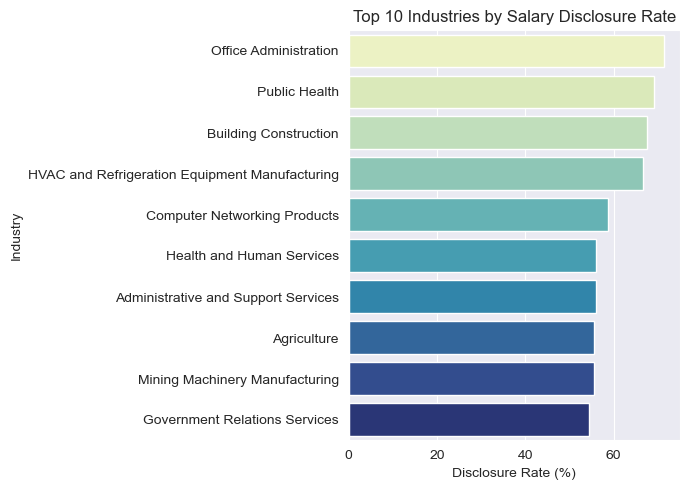

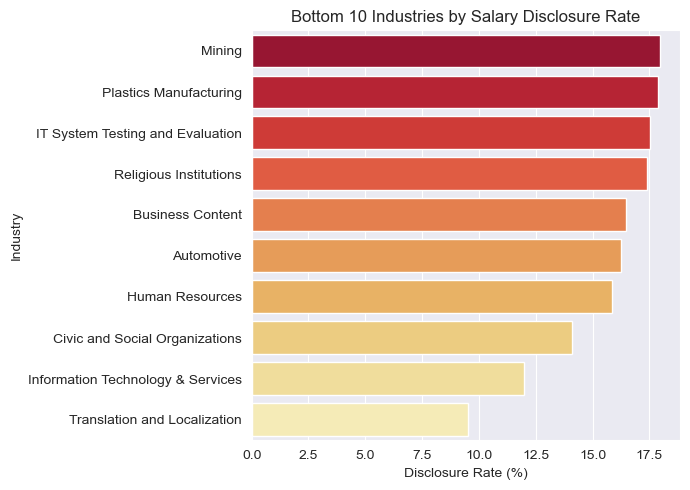

,industry,#posts,disclosure_%,group
0,Office Administration,56,71.43,Top 10
1,Public Health,172,69.19,Top 10
2,Building Construction,175,67.43,Top 10
3,HVAC and Refrigeration Equipment Manufacturing,57,66.67,Top 10
4,Computer Networking Products,99,58.59,Top 10
5,Health and Human Services,296,56.08,Top 10
6,Administrative and Support Services,102,55.88,Top 10
7,Agriculture,72,55.56,Top 10
8,Mining Machinery Manufacturing,72,55.56,Top 10
9,Government Relations Services,169,54.44,Top 10


In [35]:
salary_cols = ["min_salary", "med_salary", "max_salary"]
df_clean["has_salary_info"] = df_clean[salary_cols].notna().any(axis=1).astype(int)

df_ind = (
    df_clean
    .assign(industry_split=df_clean["industry_names"].fillna("").astype(str).str.split(","))
    .explode("industry_split")
)
df_ind["industry_split"] = df_ind["industry_split"].astype(str).str.strip()
# .ne() 排除无效的情况
df_ind = df_ind[df_ind["industry_split"].ne("") & df_ind["industry_split"].ne("Not Specified")]

min_posts = 50
counts = df_ind["industry_split"].value_counts()
keep_inds = counts[counts >= min_posts].index
df_ind = df_ind[df_ind["industry_split"].isin(keep_inds)]

ind_rate = (
    df_ind.groupby("industry_split")["has_salary_info"]
    .agg(rate="mean", n="count")
    .sort_values(["rate", "n"], ascending=[False, False])
)
ind_rate["rate_pct"] = (ind_rate["rate"] * 100).round(2)

topk = ind_rate.head(10).reset_index()
bottomk = ind_rate.tail(10).reset_index()


plt.figure(figsize=(7, 5))
sns.barplot(
    data=topk,
    x="rate_pct", y="industry_split",
    hue="industry_split", palette="YlGnBu",
    legend=False
)
plt.title("Top 10 Industries by Salary Disclosure Rate")
plt.xlabel("Disclosure Rate (%)")
plt.ylabel("Industry")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
sns.barplot(
    data=bottomk,
    x="rate_pct", y="industry_split",
    hue="industry_split", palette="YlOrRd_r",
    legend=False
)
plt.title("Bottom 10 Industries by Salary Disclosure Rate")
plt.xlabel("Disclosure Rate (%)")
plt.ylabel("Industry")
plt.tight_layout()
plt.show()

display(pd.concat([
    topk[["industry_split","n","rate_pct"]].assign(group="Top 10"),
    bottomk[["industry_split","n","rate_pct"]].assign(group="Bottom 10")
]).rename(columns={
    "industry_split": "industry",
    "n": "#posts",
    "rate_pct": "disclosure_%"
}))

#### Analysis
The dual-chart comparison highlights a clear polarization in salary transparency across industries.
At the top end, **Office Administration**, **Public Health**, and **Construction-related sectors** lead with disclosure rates around 65–70%.
These industries typically operate under **structured pay systems** and **public accountability requirements**, making salary disclosure both practical and expected.

In contrast, **Mining**, **Plastics Manufacturing**, and **Religious or Civic Organizations** record the lowest transparency (below 20%).
Their compensation models are often **non-standardized or highly variable**, and many positions rely on **seniority, project budgets, or donations**, limiting the need or ability to publish pay details.

Interestingly, even within tech-related fields, **IT System Testing** and **Information Technology Services** show relatively low disclosure rates, suggesting that **private-sector tech firms** remain cautious about publishing pay bands despite market competition.

图表对比显示不同行业的薪资公开程度存在明显分化。
在高端区间，**行政管理**、**公共卫生**和**建筑类行业**披露率最高（约 65–70%），
这些领域通常具备**标准化薪酬体系**与**公共监管要求**，薪资公开成为惯例。

相对地，**采矿业**、**塑料制造**及**宗教或社会组织**透明度最低（低于 20%），
其薪资模式多为**非标准化或高度依赖预算与资历**，公开薪酬的必要性与可行性有限。

值得注意的是，即使在科技领域，**系统测试**与**IT服务业**的薪酬披露率也相对较低，
说明**私营科技企业仍倾向保留薪资信息**，以避免市场竞争带来的薪资压力。

### 3.3 Salary Disclosure by Work Type
We further analyze how salary transparency varies by work type (e.g., Full-time, Part-time, Contract).
Since work arrangement reflects organizational and legal norms, it often correlates with compensation disclosure.

进一步分析不同**工作类型**下的薪资披露情况（如全职、兼职、合同工等）。
由于工作安排反映了组织规范与法律约束，它与薪酬公开程度往往存在关联。

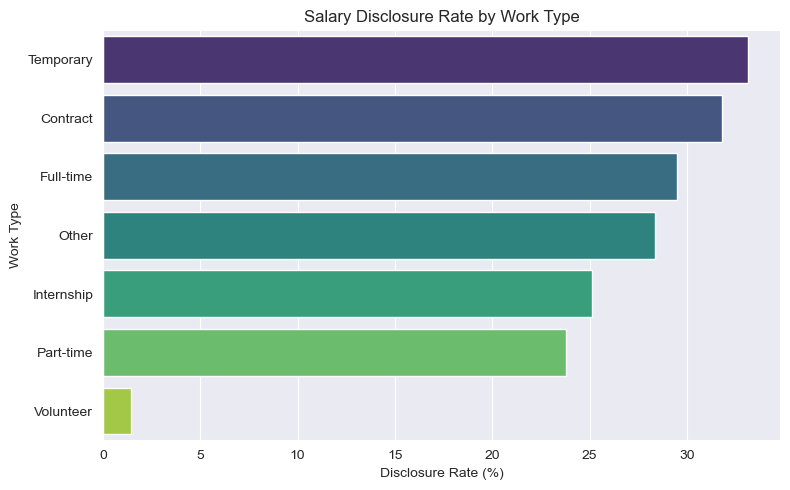

,formatted_work_type,rate,n,rate_pct
0,Temporary,0.331092,1190,33.11
1,Contract,0.317653,12117,31.77
2,Full-time,0.294827,98814,29.48
3,Other,0.283368,487,28.34
4,Internship,0.251272,983,25.13
5,Part-time,0.237624,9696,23.76
6,Volunteer,0.014235,562,1.42


In [36]:
salary_cols = ["min_salary", "med_salary", "max_salary"]
df_clean["has_salary_info"] = df_clean[salary_cols].notna().any(axis=1).astype(int)


df_worktype = (
    df_clean.groupby("formatted_work_type")["has_salary_info"]
    .agg(rate="mean", n="count")
    .sort_values("rate", ascending=False)
    .reset_index()
)
df_worktype["rate_pct"] = (df_worktype["rate"] * 100).round(2)

# 修正预处理环节后可以不用筛选了
df_worktype = df_worktype[df_worktype["n"] > 20]

plt.figure(figsize=(8,5))
sns.barplot(
    data=df_worktype,
    x="rate_pct",
    y="formatted_work_type",
    hue="formatted_work_type",
    palette="viridis",
    legend=False
)
plt.title("Salary Disclosure Rate by Work Type")
plt.xlabel("Disclosure Rate (%)")
plt.ylabel("Work Type")
plt.tight_layout()
plt.show()

df_worktype

 #### Analysis
Interestingly, **Temporary** and **Contract** roles show the highest salary disclosure rates (around 30%), even surpassing Full-time positions.
This pattern suggests that short-term or project-based work arrangements tend to **explicitly state compensation upfront**, likely because applicants evaluate such roles primarily based on pay.

Meanwhile, **Full-time** and **Other** categories follow closely behind (≈27–29%), indicating moderate transparency among regular employment positions.
**Internship** and **Part-time** postings exhibit lower rates (≈20–25%), reflecting the fact that these roles often offer fixed stipends or hourly wages that vary by region and company.
Finally, **Volunteer** roles show almost no salary disclosure, which aligns with expectations since they are generally unpaid.

有趣的是，临时工与合同工的薪资披露率最高（约 30%），甚至超过了全职岗位。
这表明短期或项目制工作更倾向于在招聘初期明确报酬，因为薪资往往是求职者决定接受的关键因素。

全职与“其他”岗位次之（约 27–29%），显示常规雇佣关系下的薪资透明度中等。
实习与兼职披露率较低（约 20–25%），可能因报酬结构差异大、以津贴或时薪为主。
最后，志愿者岗位几乎不公开薪酬，这与其“无偿服务”的特性一致。

## 4. RQ3: Uncovering Hidden Job Categories through Clustering
While previous sections focused on descriptive insights such as market demand and salary transparency,
this section adopts an **unsupervised learning approach** to reveal *latent patterns* among job postings.
By representing each job with its textual content (title, description, and skills),
we aim to group similar jobs together and identify **hidden job categories** that share common skill sets or task descriptions.

在前两章中，我们主要从描述性角度分析了市场需求和薪资透明度。
本章节转向使用**无监督学习方法**，从岗位文本信息中揭示潜在结构。
通过将每个岗位的标题、描述与技能字段组合为文本特征，
我们希望将相似的职位聚类在一起，从而识别出具有相似技能组合与职责描述的**隐藏岗位类别**。

### 4.1 Data Preparation & TF-IDF Vectorization
We first combine the textual fields (`title`, `description`, and `skill_names`) into a single column
to form a job-level textual representation.
This text is then transformed into numerical features using **TF-IDF vectorization**,
which measures how important each word is within the corpus.
We limit the vocabulary size to 5,000 and remove overly common or rare words
to ensure that clustering captures meaningful differences.

我们首先将文本类字段（`title`、`description`、`skill_names`）合并为一个完整的岗位文本表示，
然后使用 **TF-IDF 向量化** 方法将文本转化为数值特征。
该方法衡量每个词在语料库中的重要性。
为了保证聚类聚焦于有区分度的信息，我们将词汇量限制在 5,000 个，
并过滤掉过于常见或罕见的词汇。

In [37]:
df_text = df_clean.copy()

df_text["text"] = (
    df_text[["title", "description", "skill_names"]]
    .fillna("")
    .agg(" ".join, axis=1)
)

# # 取样一部分提高测试速率
# sample_size = 20000
# if len(df_text) > sample_size:
#     df_text = df_text.sample(sample_size, random_state=42).reset_index(drop=True)

print(f"prepared {len(df_text)} job postings.")

prepared 123849 job postings.


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer(
#     max_features=5000, # 只选取5000个词
#     stop_words="english",
#     lowercase=True,
#     max_df=0.8, # 去掉过于通用的词
#     min_df=5    # 去掉噪声和拼写错误
# )
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")

X_tfidf = vectorizer.fit_transform(df_text["text"])

print(f"TF-IDF matrix shape: {X_tfidf.shape}")

TF-IDF matrix shape: (123849, 5000)


**Notes / 说明：**

Each job posting is converted into a **TF-IDF vector** of up to 5,000 features.
  These features capture the relative importance of words such as *“analysis”*, *“sales”*, *“Python”*, or *“customer”*.

By doing so, we transform qualitative descriptions into a structured numerical representation
  suitable for clustering in the next step.

每个岗位被转换为一个最多 5,000 维的 TF-IDF 向量，
  用于衡量诸如 “analysis”、“sales”、“Python”、“customer” 等词汇的重要性。

这样，我们就能将非结构化文本信息转化为可进行聚类分析的结构化特征。

> 也就是 123849行文档数量（岗位）* 5000列特征数量（词汇表）的稀疏矩阵

### 4.2 Dimensionality Reduction with Truncated SVD
After obtaining high-dimensional TF-IDF vectors, we apply TruncatedSVD to reduce dimensionality and uncover latent semantic structure within the job text data.
This step transforms the sparse 5,000-dimensional space into a lower-dimensional representation (here, 50 components), capturing the dominant semantic patterns while filtering out noise.
The resulting compact embeddings serve as efficient input for subsequent clustering.

在获得高维的 TF-IDF 向量后，我们使用 TruncatedSVD 进行降维，以提取潜在的语义结构。
该步骤将稀疏的 5,000 维特征空间压缩为 50 个主要成分，从而在降低噪声的同时保留数据的主要语义特征。
降维后的紧凑向量可作为后续聚类分析的高效输入。

In [39]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

print("tf-idf shape:", X_tfidf.shape)
print("reduced shape:", X_reduced.shape)

tf-idf shape: (123849, 5000)
reduced shape: (123849, 50)


After dimensionality reduction, each job posting is represented as a 50-dimensional semantic vector.
This provides a compact representation of the textual information for later clustering.

降维后，每个岗位被表示为一个 50 维的语义向量。
这为后续的聚类分析提供了紧凑的文本特征表示。

### 4.3 Job Clustering and Keyword Extraction
After transforming job descriptions into TF-IDF vectors and reducing them via **TruncatedSVD (50 components)**, we applied **K-Means clustering (k = 5)** to group semantically similar job postings.
The optimal cluster number was determined through the combined use of **Elbow** and **Silhouette** analysis, which jointly indicated *k = 5* as the most balanced configuration.
Each cluster corresponds to a distinct occupational category identified through shared textual patterns and top-weighted terms extracted from the TF-IDF feature space.
Finally, a **PCA-based 2D visualization** presents an interpretable overview of how postings distribute across semantic dimensions, where clusters form dense but partially overlapping regions, reflecting hybrid occupations bridging multiple domains.

在将岗位描述文本转化为 TF-IDF 向量并通过 **TruncatedSVD（50 维）** 降维后，本研究使用 **K-Means 聚类（k = 5）** 对相似岗位进行语义分组。
最佳聚类数通过综合 **肘部法（Elbow）** 与 **轮廓系数法（Silhouette）** 确定，两种方法均指向 *k = 5* 为最优选择。
每个聚类代表一种独特的职业类别，通过将聚类中心映射回 TF-IDF 特征空间并提取高权重关键词来解释其语义特征。
最后，利用 **PCA 二维可视化** 展示聚类在语义空间中的分布，可见岗位形成若干密集但部分交叠的区域，反映出跨领域的复合型岗位特征。

[Elbow] k* ≈ 6   |   [Silhouette-refined] k = 5, score = -0.002


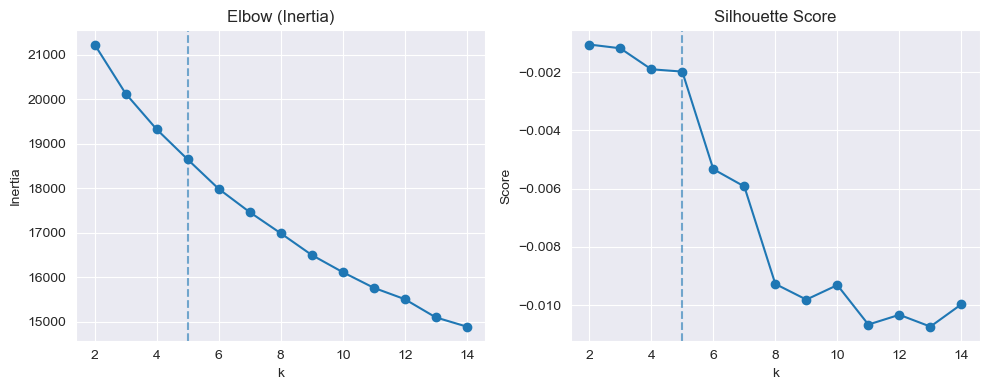

In [40]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


K = np.arange(2, 15)
inertias, sils = [], []

sample_idx = np.random.choice(X_reduced.shape[0], size=min(20000, X_reduced.shape[0]), replace=False)
X_for_sil = X_reduced[sample_idx]

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_reduced)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_for_sil, labels if X_for_sil is X_reduced else labels[:X_for_sil.shape[0]]))
    # todo: 两种方法与预期结果不统一
    #sils.append(silhouette_score(X_for_sil, labels[sample_idx]))

inertias = np.array(inertias)
sils = np.array(sils)

# 肘部法
x1, y1 = K[0], inertias[0]
x2, y2 = K[-1], inertias[-1]
den = np.hypot(x2 - x1, y2 - y1)
dist = np.abs((y2 - y1) * K - (x2 - x1) * inertias + x2 * y1 - y2 * x1) / (den + 1e-12)
elbow_k = int(K[np.argmax(dist)])

# 在肘点附近用 silhouette 精修
cand = K[(K >= elbow_k - 1) & (K <= elbow_k + 1)]
best_k = int(cand[np.argmax(sils[np.isin(K, cand)])])

print(f"[Elbow] k* ≈ {elbow_k}   |   [Silhouette-refined] k = {best_k}, score = {sils[K==best_k][0]:.3f}")


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K, inertias, marker='o'); plt.axvline(best_k, ls='--', alpha=0.6)
plt.title("Elbow (Inertia)"); plt.xlabel("k"); plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K, sils, marker='o'); plt.axvline(best_k, ls='--', alpha=0.6)
plt.title("Silhouette Score"); plt.xlabel("k"); plt.ylabel("Score")
plt.tight_layout(); plt.show()

After obtaining TF-IDF vectors and reducing them to 50 components via TruncatedSVD, we apply K-Means clustering to group semantically similar job postings.
The optimal number of clusters is determined through a combination of Elbow and Silhouette analyses.
Although minor variations may occur across multiple runs due to the inherent randomness in initialization and sampling, both metrics consistently indicate a stable range around k = 5–7.
For interpretability and simplicity, we select k = 5 as the final configuration, which provides a good balance between intra-cluster compactness and inter-cluster separation.
Each cluster represents a distinct occupational group identified through shared textual patterns.
To interpret these clusters, we project their centroids back into the original TF-IDF feature space and extract the top-weighted terms, which serve as representative keywords describing the semantic focus of each group.
Finally, a PCA-based 2D visualization provides an overview of the cluster layout, showing dense yet partially overlapping regions — a pattern that reflects hybrid job roles bridging multiple professional domains.

在获得 TF-IDF 向量并经 TruncatedSVD 压缩至 50 维后，我们使用 K-Means 聚类 对岗位文本进行语义分组。
聚类数通过综合 肘部法（Elbow） 与 轮廓系数法（Silhouette） 确定。
由于算法初始化与抽样过程存在随机性，不同运行间可能产生轻微差异，但两种方法在 k = 5–7 区间内表现稳定。
出于结果可解释性与简洁性的考虑，我们最终选择 k = 5 作为聚类数，该值在组内紧密度与组间分离度之间取得了良好平衡。
每个聚类对应一种具有共同文本特征的职业类别。
为解释各簇语义，我们将聚类中心近似映射回 TF-IDF 特征空间，并提取高权重关键词作为该类别的语义代表。
最后，通过 PCA 二维可视化 展示聚类在语义空间中的分布，可见岗位形成若干致密但部分交叠的区域，反映出跨领域复合型岗位的存在。

In [41]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_reduced)
df_text["cluster"] = labels

centers_reduced = kmeans.cluster_centers_
centers_tfidf = centers_reduced @ svd.components_

terms = np.array(vectorizer.get_feature_names_out())
topn = 12
cluster_keywords = {}
for cid in range(best_k):
    top_idx = np.argsort(centers_tfidf[cid])[::-1][:topn]
    keywords = [terms[i] for i in top_idx]
    cluster_keywords[cid] = ", ".join(keywords)
    print(f"Cluster {cid}: {cluster_keywords[cid]}")

print(f"\nnumber of clusters: {best_k}")
print(f"total samples: {len(df_text)}")

Cluster 0: work, experience, job, service, required, company, team, ability, equipment, time, position, skills
Cluster 1: store, sales, customer, customers, merchandise, retail, service, manager, associates, work, associate, team
Cluster 2: care, patient, nursing, health, patients, nurse, healthcare, medical, rn, clinical, registered, provider
Cluster 3: sales, marketing, business, customer, team, development, experience, customers, product, new, client, company
Cluster 4: project, experience, data, engineering, design, business, management, work, technical, team, accounting, software

number of clusters: 5
total samples: 123849


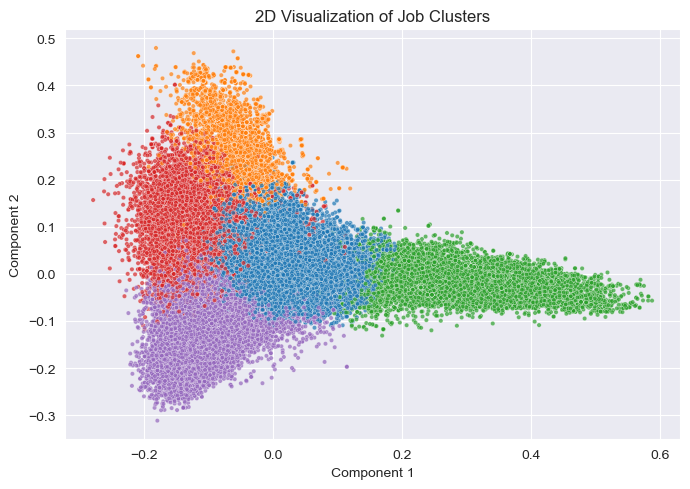

In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_reduced)

plt.figure(figsize=(7, 5))
sns.scatterplot(
    x=X_2d[:, 0], y=X_2d[:, 1],
    hue=df_text["cluster"],
    palette="tab10", s=10, alpha=0.7, legend=False
)
plt.title("2D Visualization of Job Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()

In [77]:
df_text[df_text["cluster"]==4]["title"].count()

37375

In [45]:
df_text

,job_id,company_id,title,description,location,formatted_work_type,remote_flag_simple,formatted_experience_level,skill_names,industry_names,...,closed_time,skills_desc,listed_time,sponsored,work_type,normalized_salary,fips,has_salary_info,text,cluster
0,921716,2774458.0,Marketing Coordinator,Job descriptionA leading real estate firm in N...,"Princeton, NJ",Full-time,Not Specified,Not Specified,"Marketing, Sales",Real Estate,...,NaN,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,0,FULL_TIME,38480.0,34021.0,1,Marketing Coordinator Job descriptionA leading...,3
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...","Fort Collins, CO",Full-time,Not Specified,Not Specified,Health Care Provider,Not Specified,...,NaN,NaN,1.712858e+12,0,FULL_TIME,83200.0,8069.0,1,Mental Health Therapist/Counselor At Aspen The...,2
2,10998357,64896719.0,Assitant Restaurant Manager,The National Exemplar is accepting application...,"Cincinnati, OH",Full-time,Not Specified,Not Specified,"Management, Manufacturing",Restaurants,...,NaN,We are currently accepting resumes for FOH - A...,1.713278e+12,0,FULL_TIME,55000.0,39061.0,1,Assitant Restaurant Manager The National Exemp...,0
3,23221523,766262.0,Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,"New Hyde Park, NY",Full-time,Not Specified,Not Specified,Other,Law Practice,...,NaN,This position requires a baseline understandin...,1.712896e+12,0,FULL_TIME,157500.0,36059.0,1,Senior Elder Law / Trusts and Estates Associat...,0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,"Burlington, IA",Full-time,Not Specified,Not Specified,Information Technology,Facilities Services,...,NaN,NaN,1.713452e+12,0,FULL_TIME,70000.0,19057.0,1,Service Technician Looking for HVAC service te...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123844,3906267117,56120.0,Title IX/Investigations Attorney,Our Walnut Creek office is currently seeking a...,"Walnut Creek, CA",Full-time,Not Specified,Mid-Senior level,"Business Development, Legal",Law Practice,...,NaN,NaN,1.713571e+12,0,FULL_TIME,157500.0,6013.0,1,Title IX/Investigations Attorney Our Walnut Cr...,0
123845,3906267126,1124131.0,"Staff Software Engineer, ML Serving Platform",About Pinterest:\n\nMillions of people across ...,United States,Full-time,Not Specified,Mid-Senior level,"Engineering, Information Technology","IT Services and IT Consulting, Software Develo...",...,NaN,NaN,1.713572e+12,0,FULL_TIME,NaN,NaN,0,"Staff Software Engineer, ML Serving Platform A...",4
123846,3906267131,90552133.0,"Account Executive, Oregon/Washington",Company Overview\n\nEPS Learning is a leading ...,"Spokane, WA",Full-time,Not Specified,Mid-Senior level,"Business Development, Sales",Education Administration Programs,...,NaN,NaN,1.713572e+12,0,FULL_TIME,NaN,53063.0,0,"Account Executive, Oregon/Washington Company O...",3
123847,3906267195,2793699.0,Business Development Manager,The Business Development Manager is a 'hunter'...,"Texas, United States",Full-time,Not Specified,Not Specified,"Business Development, Sales",Industrial Machinery Manufacturing,...,NaN,NaN,1.713573e+12,0,FULL_TIME,NaN,NaN,0,Business Development Manager The Business Deve...,3


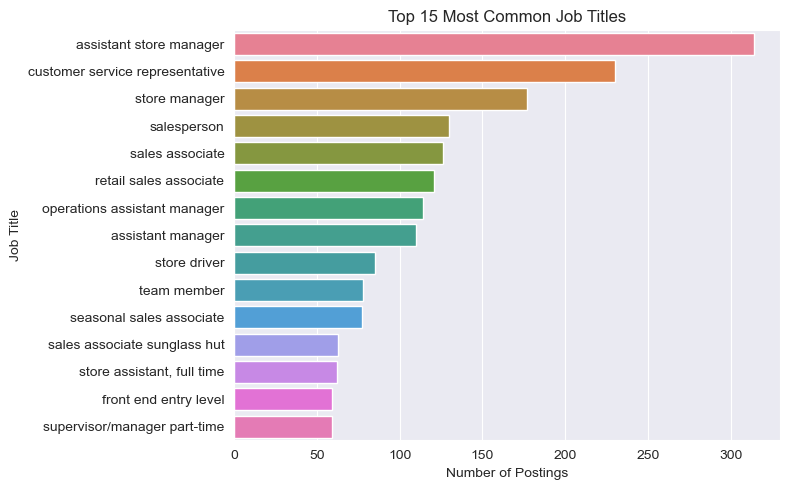

Index(['assistant store manager', 'customer service representative',
       'store manager', 'salesperson', 'sales associate'],
      dtype='object', name='title')

In [103]:
title_counts = (
    df_text[df_text["cluster"]==1]["title"].astype(str) # 确保字符串类型
    .str.lower() # 去掉首尾空格
    .value_counts() # 默认降序排列
    .head(15)
)

plt.figure(figsize=(8,5))
# 使用示例：sns.barplot(penguins, x="body_mass_g", y="island", hue="island", legend=False)
sns.barplot(
    x=title_counts.values,
    y=title_counts.index,
    hue=title_counts.index,
    legend=False
)

plt.title("Top 15 Most Common Job Titles")
plt.xlabel("Number of Postings")
plt.ylabel("Job Title")
plt.tight_layout() # 自动调整边距，文字过长图像会收缩免得不好看
plt.show()
title_counts.head(5).index

In [93]:
df_ind = (
    df_text
    .assign(industry_split=df_clean["industry_names"].fillna("").astype(str).str.split(","))
    .explode("industry_split")
)
df_ind["industry_split"] = df_ind["industry_split"].astype(str).str.strip()
# .ne() 排除无效的情况
df_ind = df_ind[df_ind["industry_split"].ne("") & df_ind["industry_split"].ne("Not Specified")]

df_ind = df_ind[df_ind["cluster"]==4]
df_ind

,job_id,company_id,title,description,location,formatted_work_type,remote_flag_simple,formatted_experience_level,skill_names,industry_names,...,skills_desc,listed_time,sponsored,work_type,normalized_salary,fips,has_salary_info,text,cluster,industry_split
6,103254301,81942316.0,Producer,Company DescriptionRaw Cereal is a creative de...,United States,Contract,Not Specified,Not Specified,"Art/Creative, Design, Information Technology",Design Services,...,NaN,1.712861e+12,0,CONTRACT,180000.0,NaN,1,Producer Company DescriptionRaw Cereal is a cr...,4,Design Services
11,11009123,93456.0,Project Architect,PGAV Destinations is seeking a self-motivated ...,"St Louis, MO",Full-time,Not Specified,Not Specified,"Art/Creative, Design, Information Technology",Architecture and Planning,...,NaN,1.712858e+12,0,FULL_TIME,NaN,29183.0,0,Project Architect PGAV Destinations is seeking...,4,Architecture and Planning
13,56924323,NaN,Structural Engineer,Universal Structural Engineers is seeking a st...,"San Mateo, CA",Full-time,Not Specified,Not Specified,Engineering,Civil Engineering,...,Job Overview: Manage a project from start to f...,1.712461e+12,0,FULL_TIME,NaN,6081.0,0,Structural Engineer Universal Structural Engin...,4,Civil Engineering
19,115639136,988555.0,Controller,WORK @ SWShannon Waltchack (SW) is seeking a C...,"Birmingham, AL",Full-time,Not Specified,Not Specified,"Accounting/Auditing, Human Resources, Management","Investment Management, Leasing Non-residential...",...,Strong interpersonal communication skills and ...,1.713210e+12,0,FULL_TIME,NaN,1073.0,0,Controller WORK @ SWShannon Waltchack (SW) is ...,4,Investment Management
19,115639136,988555.0,Controller,WORK @ SWShannon Waltchack (SW) is seeking a C...,"Birmingham, AL",Full-time,Not Specified,Not Specified,"Accounting/Auditing, Human Resources, Management","Investment Management, Leasing Non-residential...",...,Strong interpersonal communication skills and ...,1.713210e+12,0,FULL_TIME,NaN,1073.0,0,Controller WORK @ SWShannon Waltchack (SW) is ...,4,Leasing Non-residential Real Estate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123843,3906266272,122451.0,Quality Engineer,Position: Quality Engineer I (Complaint Invest...,"Irvine, CA",Contract,Not Specified,Mid-Senior level,Engineering,"Biotechnology Research, Medical Equipment Manu...",...,NaN,1.713572e+12,0,CONTRACT,83200.0,NaN,1,Quality Engineer Position: Quality Engineer I ...,4,Pharmaceutical Manufacturing
123845,3906267126,1124131.0,"Staff Software Engineer, ML Serving Platform",About Pinterest:\n\nMillions of people across ...,United States,Full-time,Not Specified,Mid-Senior level,"Engineering, Information Technology","IT Services and IT Consulting, Software Develo...",...,NaN,1.713572e+12,0,FULL_TIME,NaN,NaN,0,"Staff Software Engineer, ML Serving Platform A...",4,IT Services and IT Consulting
123845,3906267126,1124131.0,"Staff Software Engineer, ML Serving Platform",About Pinterest:\n\nMillions of people across ...,United States,Full-time,Not Specified,Mid-Senior level,"Engineering, Information Technology","IT Services and IT Consulting, Software Develo...",...,NaN,1.713572e+12,0,FULL_TIME,NaN,NaN,0,"Staff Software Engineer, ML Serving Platform A...",4,Software Development
123845,3906267126,1124131.0,"Staff Software Engineer, ML Serving Platform",About Pinterest:\n\nMillions of people across ...,United States,Full-time,Not Specified,Mid-Senior level,"Engineering, Information Technology","IT Services and IT Consulting, Software Develo...",...,NaN,1.713572e+12,0,FULL_TIME,NaN,NaN,0,"Staff Software Engineer, ML Serving Platform A...",4,Technology


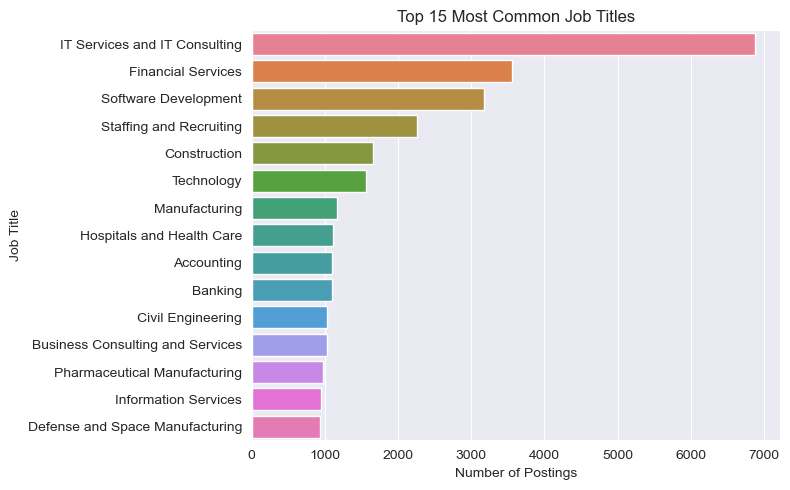

Index(['IT Services and IT Consulting', 'Financial Services',
       'Software Development'],
      dtype='object', name='industry_split')

In [94]:
title_counts = (
    df_ind["industry_split"].astype(str) # 确保字符串类型
    .str.strip() # 去掉首尾空格
    .value_counts() # 默认降序排列
    .head(15)
)

plt.figure(figsize=(8,5))
# 使用示例：sns.barplot(penguins, x="body_mass_g", y="island", hue="island", legend=False)
sns.barplot(
    x=title_counts.values,
    y=title_counts.index,
    hue=title_counts.index,
    legend=False
)

plt.title("Top 15 Most Common Job Titles")
plt.xlabel("Number of Postings")
plt.ylabel("Job Title")
plt.tight_layout() # 自动调整边距，文字过长图像会收缩免得不好看
plt.show()
title_counts.head(3).index

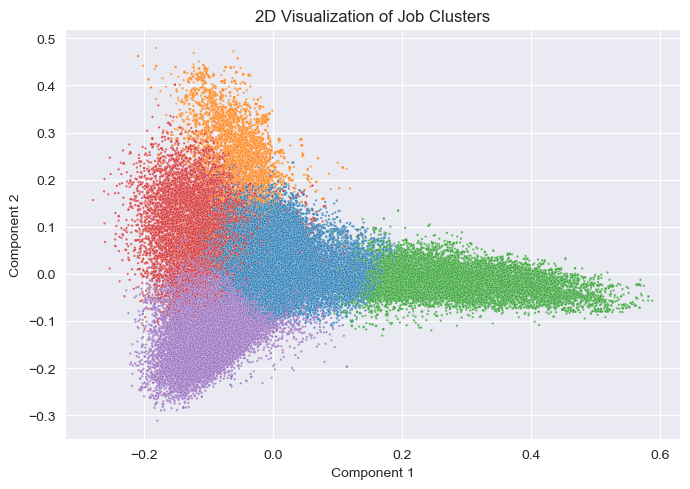

In [82]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    x=X_2d[:, 0], y=X_2d[:, 1],
    hue=df_text["cluster"],
    palette="tab10", s=3, alpha=0.7, legend=False
)
plt.title("2D Visualization of Job Clusters")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.show()

#### Analysis
The clustering process uncovered **five coherent job themes** based on textual content, following the determination of *k = 5* as the optimal number of clusters through combined Elbow and Silhouette analysis.

- **Cluster 0:** General and operational roles (*work, experience, job, service, required, company, team, skills*).
  → Represents broadly defined labor and service-oriented positions emphasizing basic ability, teamwork, and reliability.

- **Cluster 1:** Retail and customer-facing jobs (*store, sales, customer, retail, merchandise, manager, associates*).
  → Captures retail operations, sales associates, and customer service roles focused on direct consumer interaction and in-store management.

- **Cluster 2:** Healthcare and nursing occupations (*care, patient, nursing, health, medical, clinical, provider*).
  → Isolates the healthcare sector, where responsibilities center around patient care, clinical services, and registered nurse–related duties.

- **Cluster 3:** Business and marketing functions (*sales, marketing, business, customer, development, product, client*).
  → Encompasses roles in corporate sales, marketing strategy, and business development, where relationship management and client acquisition dominate.

- **Cluster 4:** Technical, engineering, and data roles (*project, data, engineering, design, management, technical, software*).
  → Includes engineers, project managers, and data professionals emphasizing analytical and technical expertise.

The PCA visualization demonstrates that postings form five dense but partially overlapping clusters, indicating that hybrid job types (e.g., business-technical or marketing-data roles) connect multiple occupational domains.
Overall, the model effectively differentiates the major employment sectors—**operational, retail, healthcare, business, and technical**—confirming that unsupervised text clustering can capture meaningful structural segmentation in the labor market.

---

聚类结果揭示了基于文本语义的**五类主要岗位主题**。通过肘部法与轮廓系数法确定最佳聚类数为 *k = 5*，模型成功划分出以下几类：

- **Cluster 0：** 综合与运营类岗位（*work, experience, job, service, company, team, skills*）
  → 代表通用型劳务与服务岗位，注重基础能力与团队协作。

- **Cluster 1：** 零售与客户服务类岗位（*store, sales, customer, retail, merchandise, manager, associates*）
  → 覆盖零售销售、门店管理及客户服务职位，面向顾客与前线运营。

- **Cluster 2：** 医疗与护理类岗位（*care, patient, nursing, health, medical, clinical, provider*）
  → 聚焦医疗护理领域，职责围绕病患照护与临床支持。

- **Cluster 3：** 商业与市场类岗位（*sales, marketing, business, customer, development, product, client*）
  → 包含企业销售、市场推广及商务拓展相关角色，强调客户关系与业务增长。

- **Cluster 4：** 技术与工程类岗位（*project, data, engineering, design, management, software*）
  → 包括工程师、项目经理及数据分析等职位，侧重技术与分析能力。

从 PCA 二维可视化 可见，五个类群在语义空间中形成若干密集区域，虽然部分边界存在交叠，但整体区分度良好。
这表明无监督文本聚类能够有效识别劳动市场中的主要职业分层，捕捉出 **运营、零售、医疗、商务与技术** 等关键领域的语义特征与行业边界。

## 5. RQ4: Skill Premium and Salary Gap Analysis
This chapter examines whether certain skills are associated with higher salaries.
We use postings that disclose any salary field and compare pay across individual skills.

本章节研究不同技能是否与更高薪资相关。
我们选取公开任一薪资字段的岗位，按单一技能进行薪资对比与汇总。

### 5.1 Data Preparation for Skill–Salary Analysis
We build a single numeric salary proxy per posting (prefer `med_salary`; otherwise the mean of `min_salary` and `max_salary`).
Then we split `skill_names` into single tags, explode to one row per (job, skill), and aggregate salary by skill.
To ensure stability, we keep only skills with sufficient samples.

构建每条岗位的**单一薪资数值**（优先 `med_salary`，否则用 `min_salary` 与 `max_salary` 的均值）。
将 `skill_names` 拆分为单个技能并展开为（岗位，技能）逐行记录；
按技能聚合薪资；为保证稳健性，仅保留**样本量充足**的技能。

In [31]:
df_s = df_clean.copy()


df_s = df_s[df_s["pay_period"].fillna("Not Specified").isin(["YEARLY", "Not Specified"])]
df_s = df_s[df_s["currency"].fillna("USD").isin(["USD", "Not Specified"])]


for c in ["min_salary", "med_salary", "max_salary"]:
    df_s[c] = pd.to_numeric(df_s[c], errors="coerce")

df_s["has_any_salary"] = df_s[["min_salary", "med_salary", "max_salary"]].notna().any(axis=1)
df_s = df_s[df_s["has_any_salary"]].copy()

df_s["salary_num"] = np.where(
    df_s["med_salary"].notna(),
    df_s["med_salary"],
    df_s[["min_salary", "max_salary"]].mean(axis=1)
)

df_s = df_s[df_s["salary_num"].notna()].copy()


df_s["skill_list"] = df_s["skill_names"].fillna("").astype(str).str.split(",")
df_s = df_s.explode("skill_list")
df_s["skill"] = df_s["skill_list"].astype(str).str.strip()
df_s = df_s[(df_s["skill"] != "") & (df_s["skill"].str.lower() != "not specified")].copy()


skill_agg = (
    df_s.groupby("skill", as_index=False)
    .agg(n_posts=("job_id", "count"),
         mean_salary=("salary_num", "mean"),
         median_salary=("salary_num", "median"))
)

# 去掉小样本的职业技能
min_posts = 50
skill_salary = (
    skill_agg[skill_agg["n_posts"] >= min_posts]
    .sort_values("mean_salary", ascending=False)
    .reset_index(drop=True)
)

print("skills kept:", skill_salary.shape[0])
skill_salary.head(20)

skills kept: 35


,skill,n_posts,mean_salary,median_salary
0,Marketing,1157,207198.618777,105000.00
1,Product Management,394,155572.286409,150000.00
2,Legal,799,150270.290851,132500.00
3,Science,175,142345.095600,130000.00
4,Health Care Provider,1053,138751.772303,110000.00
5,Engineering,2721,137443.353809,128554.50
6,Strategy/Planning,404,134423.085817,124825.00
7,Sales,3996,134052.491333,92500.00
8,Research,591,131347.590440,113000.00
9,Information Technology,4624,129217.364059,122500.00


### 5.2 Top-Paying Skills

We now examine which skills are associated with the highest average salaries among postings that disclosed pay.
To ensure reliability, only skills with at least 50 postings were retained.
The following results summarize the top-paying skill categories based on mean and median salary values.

我们进一步分析在公开薪资的岗位中，哪些技能对应的平均薪资最高。
为保证稳健性，仅保留样本量在 50 条以上的技能。
下表总结了平均薪资最高的技能类别。

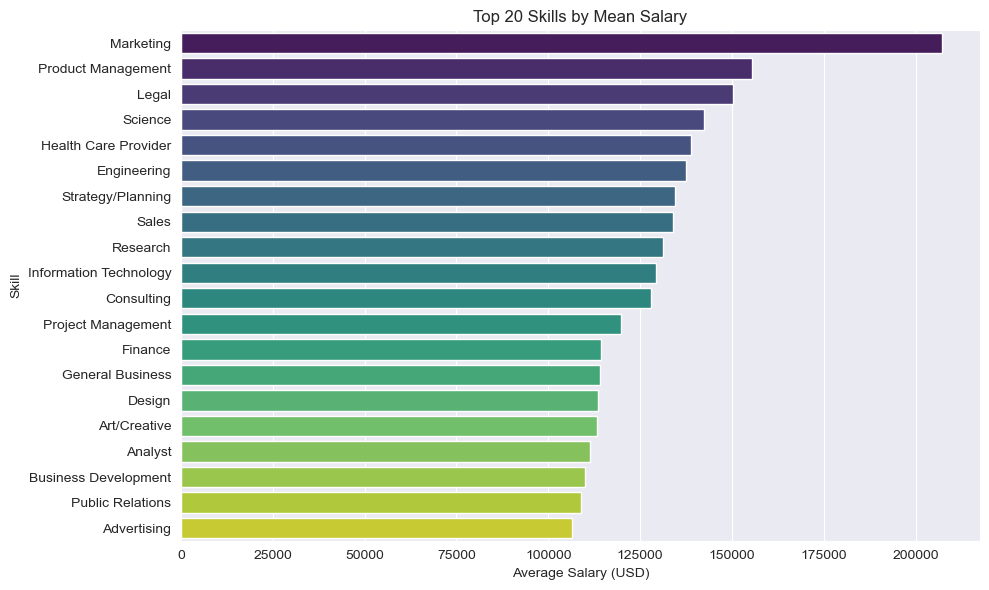

,skill,n_posts,mean_salary,median_salary
0,Marketing,1157,207198.618777,105000.0
1,Product Management,394,155572.286409,150000.0
2,Legal,799,150270.290851,132500.0
3,Science,175,142345.095600,130000.0
4,Health Care Provider,1053,138751.772303,110000.0
5,Engineering,2721,137443.353809,128554.5
6,Strategy/Planning,404,134423.085817,124825.0
7,Sales,3996,134052.491333,92500.0
8,Research,591,131347.590440,113000.0
9,Information Technology,4624,129217.364059,122500.0


In [32]:
top20 = skill_salary.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top20,
    x="mean_salary",
    y="skill",
    hue="skill",
    palette="viridis",
    legend=False
)

plt.title("Top 20 Skills by Mean Salary")
plt.xlabel("Average Salary (USD)")
plt.ylabel("Skill")
plt.tight_layout()
plt.show()

top20[["skill", "n_posts", "mean_salary", "median_salary"]].head(10)

#### Analysis

The results reveal a clear skill premium — certain professional domains command substantially higher salaries.
At the top, *Marketing* stands out with an average salary exceeding USD 200,000,
followed by *Product Management* and *Legal*, both around USD 150,000–160,000.
These are typically strategic or leadership-intensive roles, requiring cross-functional coordination, business judgment, and decision-making responsibility.

结果揭示了明显的技能溢价效应——部分专业领域的薪资显著更高。
其中，Marketing 平均薪资超过 20 万美元，
紧随其后的是 Product Management 与 Legal，约 15–16 万美元，
这些通常属于战略性或高决策责任岗位，需要跨部门协作与商业判断力。

From a technical perspective, *Engineering* and *Information Technology* remain among the top-paying skills,
with salaries clustering around USD 130,000–140,000.
This reflects sustained demand for technical professionals, though their salary level is now comparable to high-end business functions,
suggesting a growing equilibrium between business acumen and technical expertise in the labor market.

从技术角度看，Engineering 与 Information Technology 仍位居高薪前列，
平均薪资约在 13–14 万美元，反映出市场对技术型岗位的持续需求。
但其薪资水平已与高级商业岗位相近，说明商业与技术复合型人才成为新趋势。

Conversely, creative and support-oriented skills — such as *Design*, *Public Relations*, and *Advertising* —
lie in the lower tier, with mean salaries closer to USD 100,000.
These roles remain essential but typically lack the high leverage or profit-linked incentives of strategic management and engineering positions.

相对而言，Design、Public Relations（公关）、Advertising 等创意与支持类岗位处于薪资下层，
平均薪资约 10 万美元左右。这些岗位虽仍重要，但通常不直接带来高利润或战略影响。

Overall, the salary distribution confirms that cross-domain integration
is increasingly valuable.
Skills that bridge multiple functions — such as *Product Management* and *Engineering Management* — are becoming top earners,
illustrating the market’s preference for hybrid expertise.

总体来看，数据表明跨界整合能力愈发受到青睐，
企业倾向于为兼具商业与技术视野的人才支付更高报酬。

### 5.3 Skill Popularity and Compensation Correlation
To quantify whether popular skills also yield higher salaries, we complement the visual inspection with a **Pearson correlation test**.
By plotting a log-scaled regression between the number of postings (skill frequency) and mean salary, and computing their correlation coefficient, we can assess the strength and direction of the relationship.
This approach helps determine if the observed upward trend in the scatter plot is statistically meaningful.

为验证热门技能是否对应更高的薪资，本节在可视化基础上引入 **皮尔逊相关分析**。
我们将技能发布频次（对数尺度）与平均薪资进行线性拟合，并计算其相关系数以量化关系强度。
该方法能够检验散点图中轻微上升趋势是否具有统计意义。

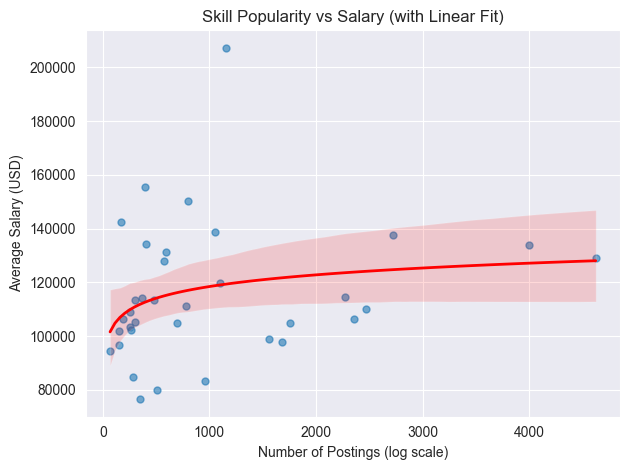

pearson correlation: r=0.202, p-value=0.244


In [110]:
from scipy.stats import pearsonr

sns.regplot(
    data=skill_salary,
    x="n_posts", y="mean_salary",
    scatter_kws={'alpha':0.6, 's':25},
    line_kws={'color':'red', 'lw':2},
    logx=True
)
plt.title("Skill Popularity vs Salary (with Linear Fit)")
plt.xlabel("Number of Postings (log scale)")
plt.ylabel("Average Salary (USD)")
plt.tight_layout()
plt.show()

# 计算皮尔逊相关系数
r, p = pearsonr(skill_salary["n_posts"], skill_salary["mean_salary"])
print(f"pearson correlation: r={r:.3f}, p-value={p:.3g}")

#### Analysis
The computed Pearson correlation coefficient (**r = 0.202, p = 0.244**) indicates that the relationship between skill popularity and average salary is **weak and statistically insignificant**.
Although the regression line in the scatter plot shows a slight upward slope, the high p-value suggests that this trend could easily arise by chance rather than reflecting a consistent market pattern.
This means that skills frequently appearing in job postings—such as communication, teamwork, or customer service—do not necessarily correspond to higher compensation.
In contrast, niche and specialized skills (e.g., legal, data science, cloud computing) tend to yield higher salaries despite lower posting volumes.
Hence, **skill rarity, not market popularity, appears to be the stronger determinant of pay level**.

计算得到的皮尔逊相关系数（**r = 0.202, p = 0.244**）表明技能热度与平均薪资之间的关系**较弱且不具有统计显著性**。
虽然散点图中的回归线略呈上升趋势，但较高的 p 值说明这一趋势很可能只是随机波动的结果，而非市场规律。
这意味着，在招聘信息中频繁出现的技能（如沟通、团队合作、客户服务等）并不一定对应更高薪资；
相反，**法律、数据科学、云计算**等稀缺或高技术含量技能尽管出现频率较低，却往往能获得更高的报酬。
因此，可以推断：**决定薪资水平的关键因素是技能的稀缺性，而非市场上的普及程度。**


### 5.4 Skill Combination and Salary Uplift
We test whether skill combinations (pairs) are associated with higher pay than the same skills used individually.
For each posting we compute a single salary number, build unique skill sets, generate in-job pairs, and compare the pair’s mean salary against the baseline of its two single-skill means.
We then visualize the top uplift pairs to highlight combinations that appear to command a pay premium.

本节检验技能组合是否较单一技能带来更高薪资：为每条岗位得到一个薪资数值、生成岗位内技能对，并将组合均薪与两单技能均薪的平均作比较，最后展示溢价最高的组合。

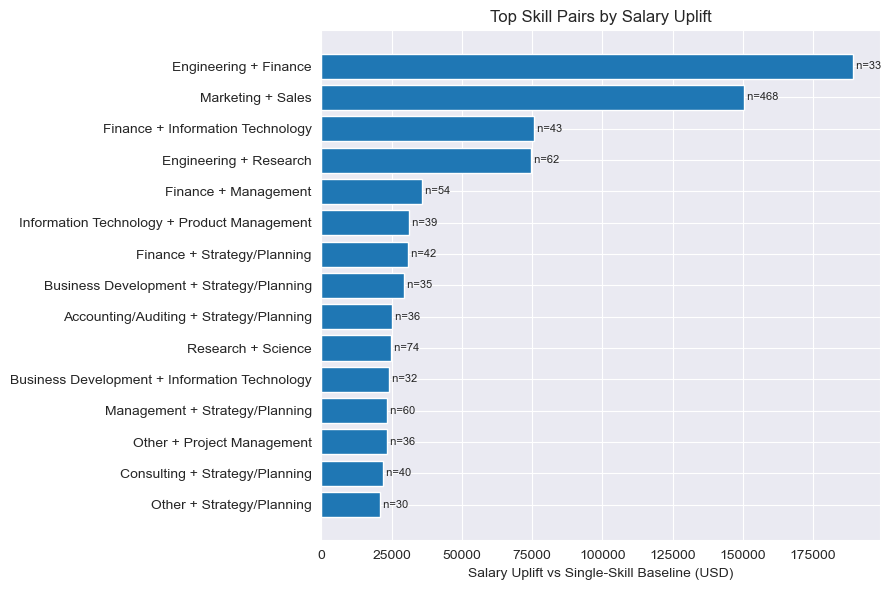

,skill_a,skill_b,n_pair,mean_pair,baseline_ab,uplift
0,Engineering,Finance,33,315345.454545,125927.959479,189417.495066
1,Marketing,Sales,468,321204.816293,170625.555055,150579.261238
2,Finance,Information Technology,43,197416.279070,121814.964604,75601.314465
3,Engineering,Research,62,209004.524194,134395.472125,74609.052069
4,Finance,Management,54,146184.694444,110428.642270,35756.052175
5,Information Technology,Product Management,39,173399.641026,142394.825234,31004.815792
6,Finance,Strategy/Planning,42,155063.095238,124417.825483,30645.269755
7,Business Development,Strategy/Planning,35,151701.000000,122266.404288,29434.595712
8,Accounting/Auditing,Strategy/Planning,36,144792.597222,119681.466075,25111.131147
9,Research,Science,74,161618.877027,136846.343020,24772.534007


In [34]:
from itertools import combinations

dfp = df_clean.copy()

dfp = dfp[dfp["pay_period"].eq("YEARLY")]
dfp = dfp[dfp["currency"].eq("USD")]

sal_cols = ["min_salary","med_salary","max_salary"]
dfp[sal_cols] = dfp[sal_cols].apply(pd.to_numeric, errors="coerce")
dfp = dfp[dfp[sal_cols].notna().any(axis=1)].copy()
dfp["salary_num"] = dfp["med_salary"].combine_first(dfp[["min_salary","max_salary"]].mean(axis=1))
dfp = dfp[dfp["salary_num"].notna()].copy()

# 每个岗位的去重技能集合
def clean_skills(x):
    if not isinstance(x, str):
        return []
    xs = [s.strip() for s in x.split(",")]
    xs = [s for s in xs if s and s.lower() != "not specified"]
    return sorted(set(xs))

dfp["skills"] = dfp["skill_names"].fillna("").astype(str).map(clean_skills)

# 技能统计
singles = dfp.loc[:, ["job_id","salary_num","skills"]].explode("skills").rename(columns={"skills":"skill"})
singles = singles[singles["skill"].ne("")]
single_stats = singles.groupby("skill")["salary_num"].agg(count="count", mean="mean")

# 技能对统计
pairs = dfp.loc[dfp["skills"].str.len().ge(2), ["job_id","salary_num","skills"]].copy()
pairs = pairs.assign(pair=pairs["skills"].apply(lambda s: list(combinations(s, 2)))).explode("pair")
pairs[["skill_a","skill_b"]] = pd.DataFrame(pairs["pair"].tolist(), index=pairs.index)

pair_stats = (pairs.groupby(["skill_a","skill_b"])["salary_num"]
                   .agg(n_pair="count", mean_pair="mean")
                   .reset_index())

mean_map = single_stats["mean"].to_dict()
cnt_map  = single_stats["count"].to_dict()

pair_stats["mean_a"] = pair_stats["skill_a"].map(mean_map)
pair_stats["mean_b"] = pair_stats["skill_b"].map(mean_map)
pair_stats["n_a"]    = pair_stats["skill_a"].map(cnt_map)
pair_stats["n_b"]    = pair_stats["skill_b"].map(cnt_map)

pair_stats["baseline_ab"] = pair_stats[["mean_a","mean_b"]].mean(axis=1)
pair_stats["uplift"] = pair_stats["mean_pair"] - pair_stats["baseline_ab"]

min_pair, min_single, topN = 30, 50, 15
top_pairs = (pair_stats.query("n_pair>=@min_pair and n_a>=@min_single and n_b>=@min_single")
                        .sort_values(["uplift","mean_pair","n_pair"], ascending=[False,False,False])
                        .head(topN)
                        .assign(label=lambda d: d["skill_a"] + " + " + d["skill_b"])
                        .reset_index(drop=True))

plt.figure(figsize=(9,6))
y = np.arange(len(top_pairs))
plt.barh(y, top_pairs["uplift"])
plt.yticks(y, top_pairs["label"])
plt.gca().invert_yaxis()
plt.xlabel("Salary Uplift vs Single-Skill Baseline (USD)")
plt.title("Top Skill Pairs by Salary Uplift")
for i, n in enumerate(top_pairs["n_pair"]):
    plt.text(top_pairs["uplift"].iloc[i], i, f" n={n}", va="center", ha="left", fontsize=8)
plt.tight_layout()
plt.show()

top_pairs[["skill_a","skill_b","n_pair","mean_pair","baseline_ab","uplift"]]

#### Analysis
The bar chart displays the **top skill combinations** that correspond to higher average salaries compared to their individual-skill baselines.
Each horizontal bar represents the **salary uplift** (in USD), showing how much more the paired skill combination earns on average.
The numbers labeled as “n=xx” on the right side indicate the **number of job postings** in which that skill pair co-occurred — serving as a measure of reliability and sample size.
For example, although *Engineering + Finance* and *Marketing + Sales* exhibit strong positive uplifts, they differ greatly in sample support (n=33 vs n=468), suggesting that some pairs may represent niche, high-value intersections rather than widespread patterns.

Overall, the results highlight that **cross-domain skill combinations**—especially those blending **technical and business expertise** (e.g., *Engineering + Finance*, *Finance + IT*, *Information Technology + Product Management*)—tend to command significantly higher compensation.
This implies that **interdisciplinary capabilities** are rewarded in the labor market, as they enable professionals to bridge technical implementation and strategic decision-making.

该图展示了相较单一技能，**技能组合带来的薪资溢价**。
每个横条表示该技能组合的平均薪资较两单技能基线的提升幅度（美元），右侧的 “n=xx” 表示该技能组合在样本中共同出现的**岗位数量**，反映其统计可靠性。
例如，*Engineering + Finance* 与 *Marketing + Sales* 均表现出显著的正向溢价，但样本量差异较大（33 vs 468），说明部分高溢价组合可能代表**小众但高价值的岗位交叉领域**。

总体而言，结果表明**跨领域技能组合**（尤其是融合**技术与商业能力**的组合，如 *Engineering + Finance*、*Finance + IT*、*Information Technology + Product Management*）在薪资上显著占优。
这说明劳动力市场对**复合型人才**给予了更高回报，他们能够在技术实现与战略管理之间起到桥梁作用。